In [1]:
from pprint import pprint
import pandas as pd
import numpy as np
import scipy as sp
import pickle
import cloudpickle
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from comparers import ModelComparer, plot_decision_boundary
from util import RuleClassifier, get_complexity, find_counterfactuals, counterfactuals_to_constraint_matrix,\
                 evaluate, group_metrics
from explainers import generate_shap_explanations, calc_feature_order, calc_class_order,\
                       plot_feature_importance_bar, plot_class_importances, print_rules
from clustering import make_clustering, eval_clusterings, plot_2d_with_boundaries, compare_indiv_dep_plots
import matplotlib.pyplot as plt
from IPython.display import display
import shap
import warnings
shap.initjs()
warnings.filterwarnings(action='ignore', category=UserWarning)  # xgboost classifiers print lots of warnings

In [2]:
with open('task.pickle', 'rb') as f:
    clf_a, clf_b, X, X_display, y, feature_names, categorical_features, feature_precisions = pickle.load(f)

In [3]:
comparer = ModelComparer(clf_a, clf_b, feature_names)

In [4]:
# Do not sample from background data set, use all
masker = shap.maskers.Independent(data=X, max_samples=len(X))

In [5]:
def load(focus_class):
    with open(f'clustering.diffclf.{focus_class}.pickle', 'rb') as f:
        state = pickle.load(f)
    node = make_clustering(comparer, diffclf_shap_values, focus_class,
                           categorical_features=categorical_features,
                           feature_precisions=feature_precisions, state=state)
    return node

# Generate Explanations

In [6]:
%%time
indiv_shap_values = generate_shap_explanations(comparer, X, masker=masker, explanation_type='indiv', space_type='log_odds')
diffclf_shap_values = generate_shap_explanations(comparer, X, masker=masker, explanation_type='mclass_diff', space_type='log_odds')
with open('indiv.log_odds.shap', 'wb') as f:
    pickle.dump(indiv_shap_values, f, pickle.HIGHEST_PROTOCOL)
with open('diffclf.log_odds.shap', 'wb') as f:
    pickle.dump(diffclf_shap_values, f, pickle.HIGHEST_PROTOCOL)

Permutation explainer: 101it [00:12,  1.98it/s]                        
Permutation explainer: 101it [00:11,  1.15it/s]                        


CPU times: user 1min 1s, sys: 3.49 s, total: 1min 4s
Wall time: 23.5 s


In [7]:
%%time
for class_name in comparer.class_names:
    print(class_name)
    node = make_clustering(comparer, diffclf_shap_values, class_name,
                           feature_precisions=feature_precisions)
    with open(f'clustering.diffclf.{node.focus_class}.pickle', 'wb') as f:
        pickle.dump(node.state, f)

(False, False)
(False, True)
(True, False)
(True, True)
CPU times: user 7h 59min, sys: 35min 57s, total: 8h 34min 57s
Wall time: 2h 51min 51s


# Individual Explanations

In [38]:
with open('indiv.log_odds.shap', 'rb') as f:
    indiv_shap_values = pickle.load(f)

In [39]:
# For binary classification problems only the positive class is interesting
indiv_shap_values = indiv_shap_values[:, :, ['A.True', 'B.True']]

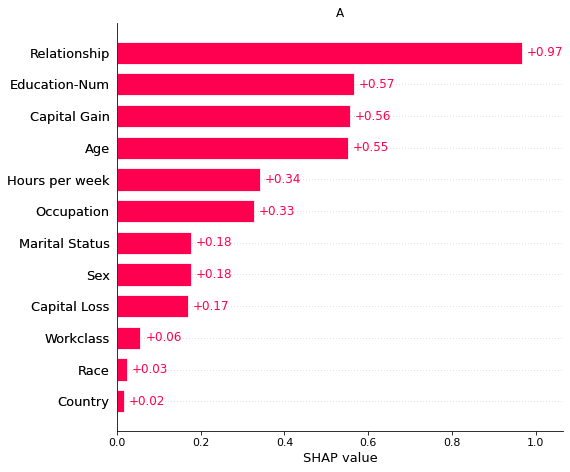

In [40]:
feature_order, feature_importance = calc_feature_order(indiv_shap_values[:, :, 'A.True'])
plot_feature_importance_bar(feature_importance, 'A', feature_order)

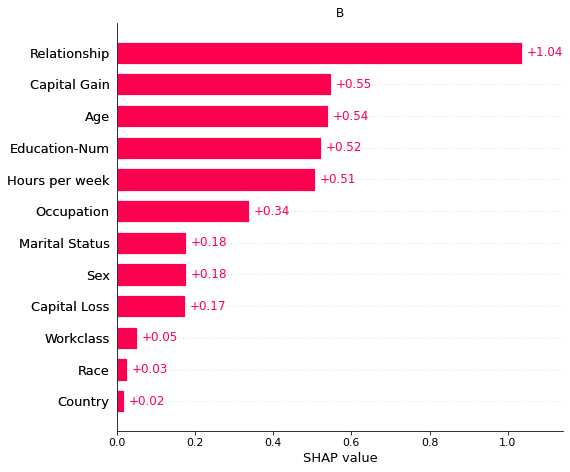

In [41]:
feature_order, feature_importance = calc_feature_order(indiv_shap_values[:, :, 'B.True'])
plot_feature_importance_bar(feature_importance, 'B', feature_order)

In [42]:
%%time
node = make_clustering(comparer, indiv_shap_values)

CPU times: user 1.19 s, sys: 313 ms, total: 1.5 s
Wall time: 1.14 s


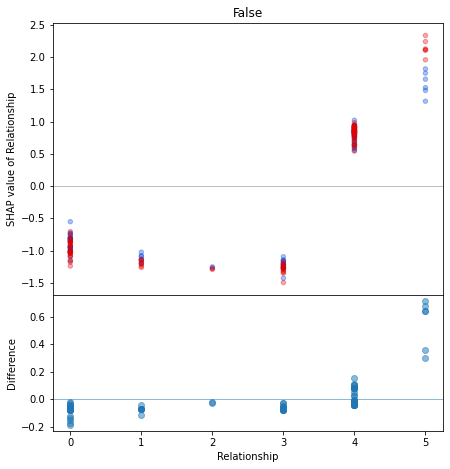

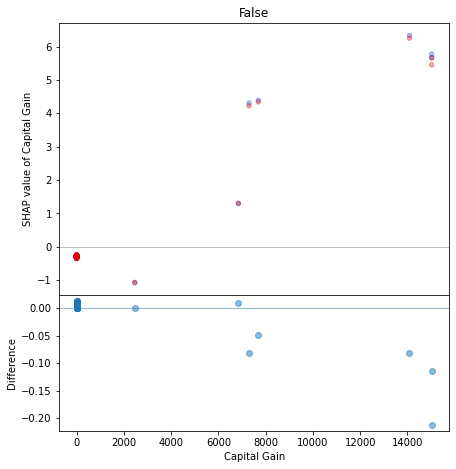

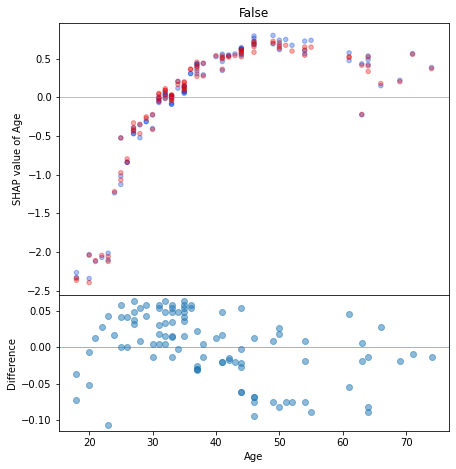

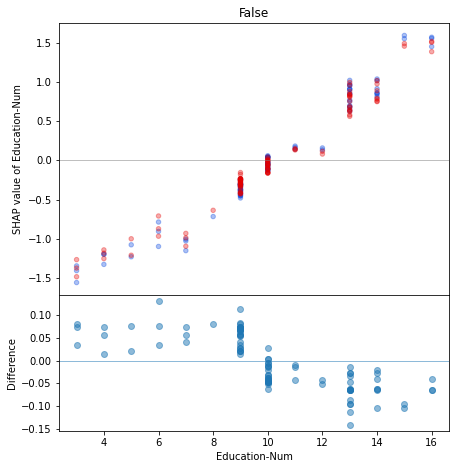

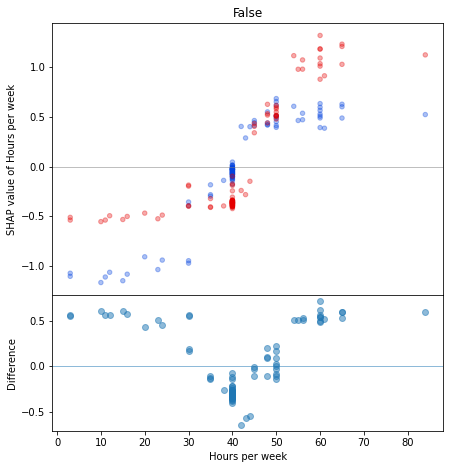

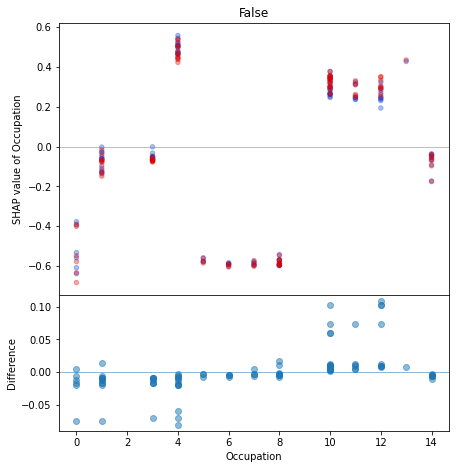

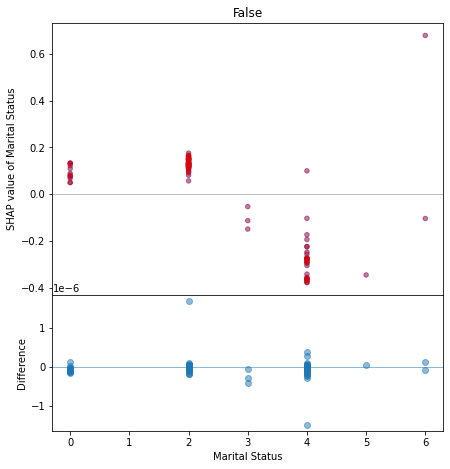

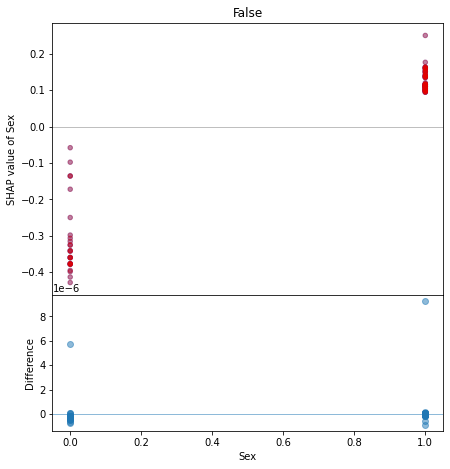

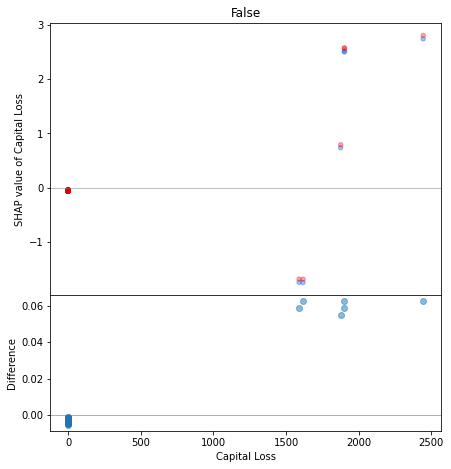

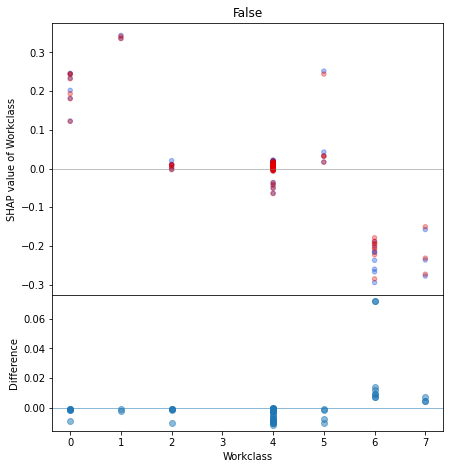

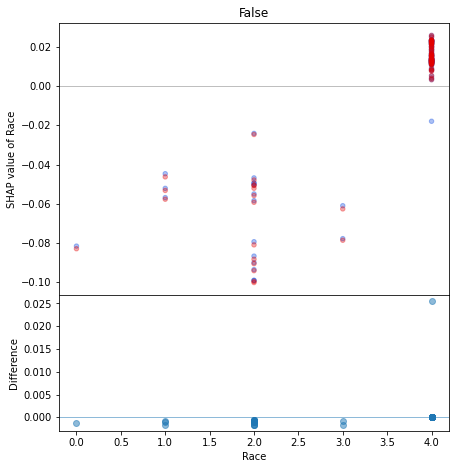

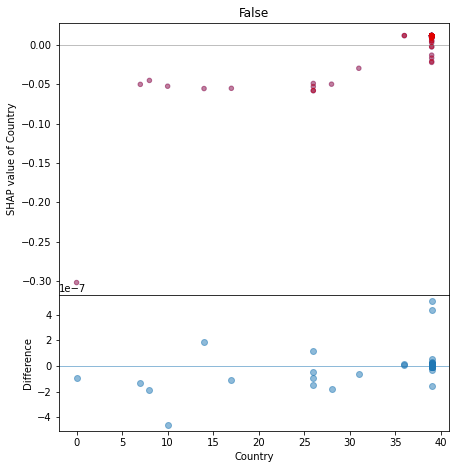

In [43]:
compare_indiv_dep_plots(node)

# Difference Classifier Explanations

In [44]:
with open('diffclf.log_odds.shap', 'rb') as f:
    diffclf_shap_values = pickle.load(f)

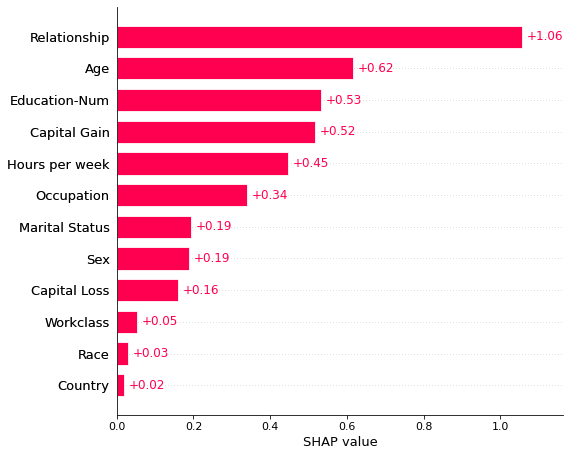

In [45]:
feature_order, feature_importances = calc_feature_order(diffclf_shap_values)
plot_feature_importance_bar(feature_importances)

## Clustering of Class $(True, False)$ SHAP Values

In [46]:
node = load('(True, False)')
node.class_counts, node.distance

((False, False)    78
 (True, True)      17
 (True, False)      5
 dtype: int64,
 281.1685447247144)

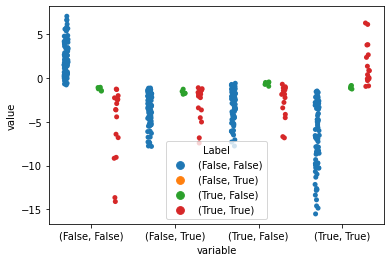

In [47]:
node.plot_outcomes()

### Main Node (RL)

In [48]:
node = node.get_last_child_before_focus_class_split()
node, node.class_counts, node.distance

(RL,
 (False, False)    33
 (True, True)      12
 (True, False)      5
 dtype: int64,
 79.28268292947294)

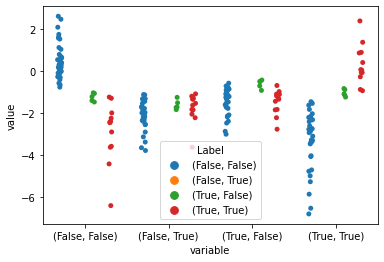

In [49]:
node.plot_outcomes()

Relationship <= 4.0
[]


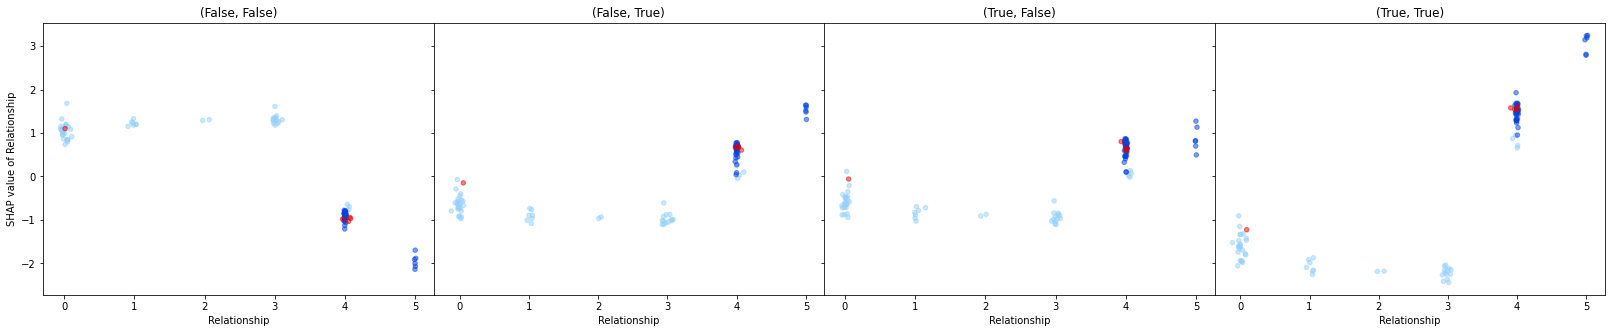

32.0 <= Age <= 50.0
[Lower CF: Age == 26.0 --> {'(False, False)': 5}]


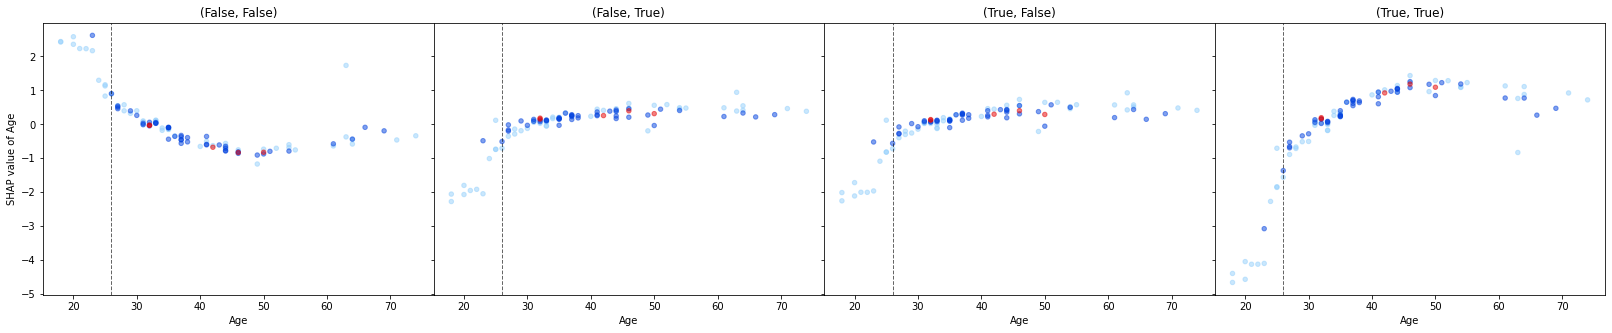

10.0 <= Education-Num <= 13.0
[Lower CF: Education-Num == 8.0 --> {'(False, False)': 5}]


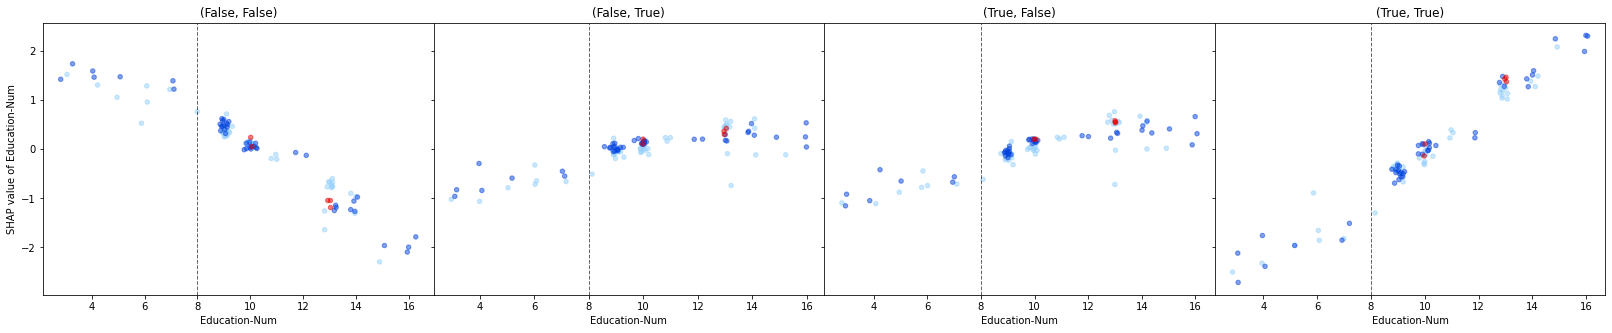

Capital Gain == 0.0
[Upper CF: Capital Gain == 57.0 --> {'(False, False)': 5}]


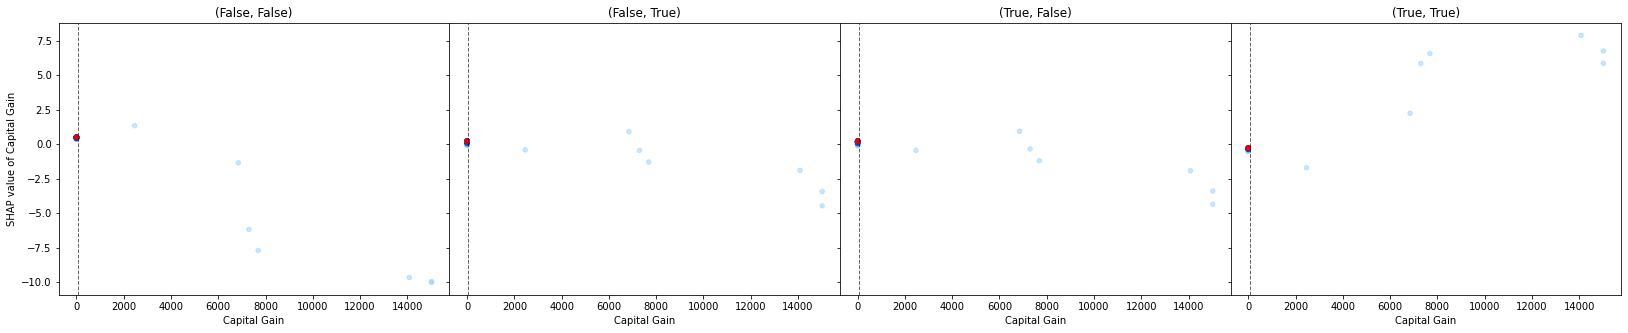

40.0 <= Hours per week <= 48.0
[Lower CF: Hours per week == 34.0 --> {'(False, False)': 5},
 Upper CF: Hours per week == 55.0 --> {'(True, True)': 5}]


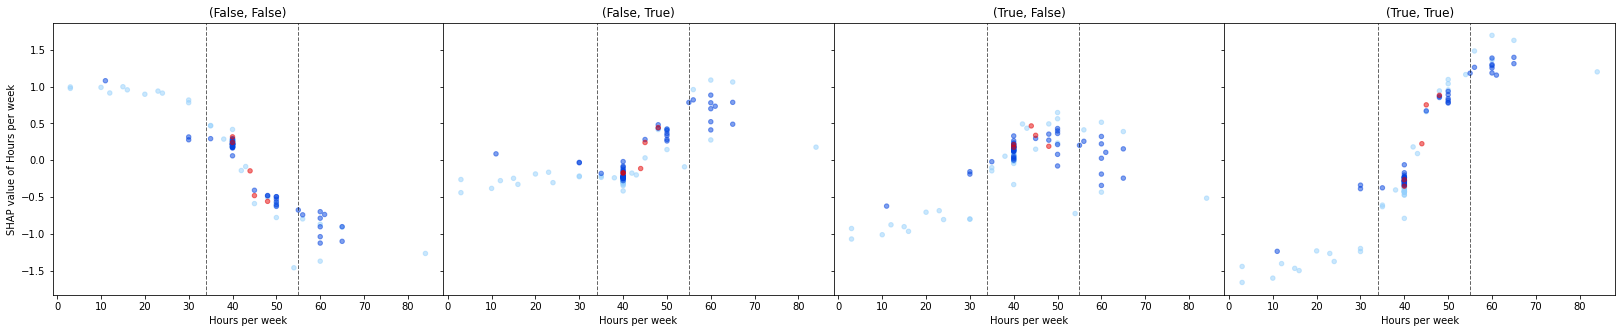

4.0 <= Occupation
[]


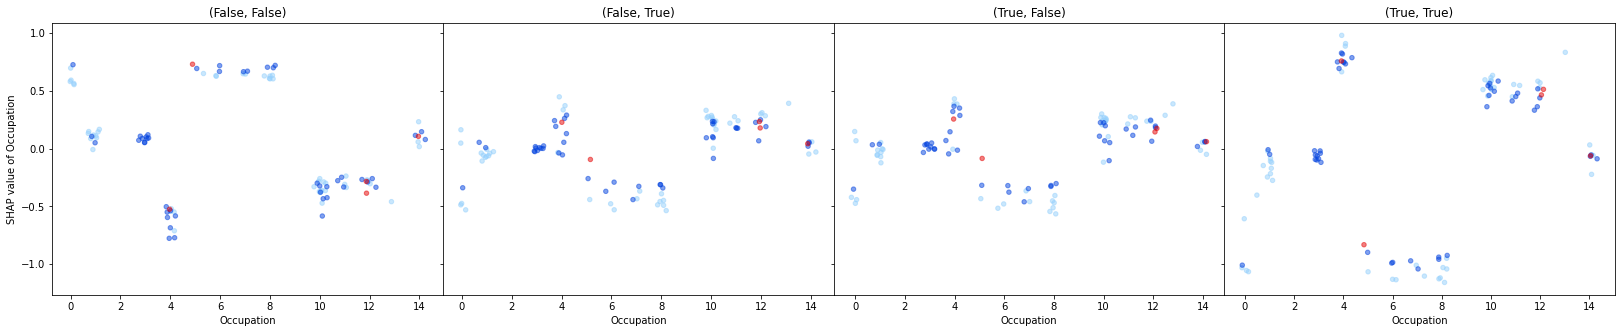

2.0 <= Marital Status <= 4.0
[]


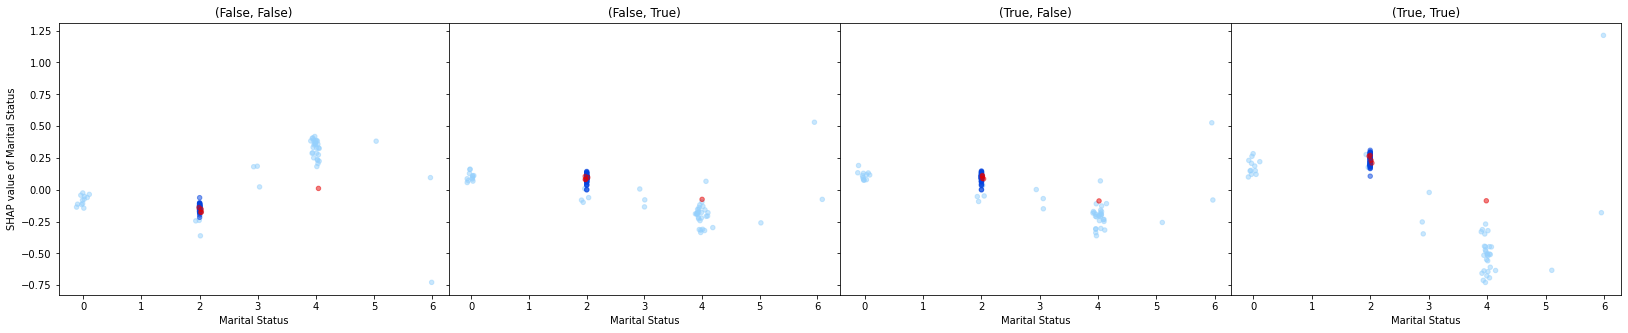

Sex
[]


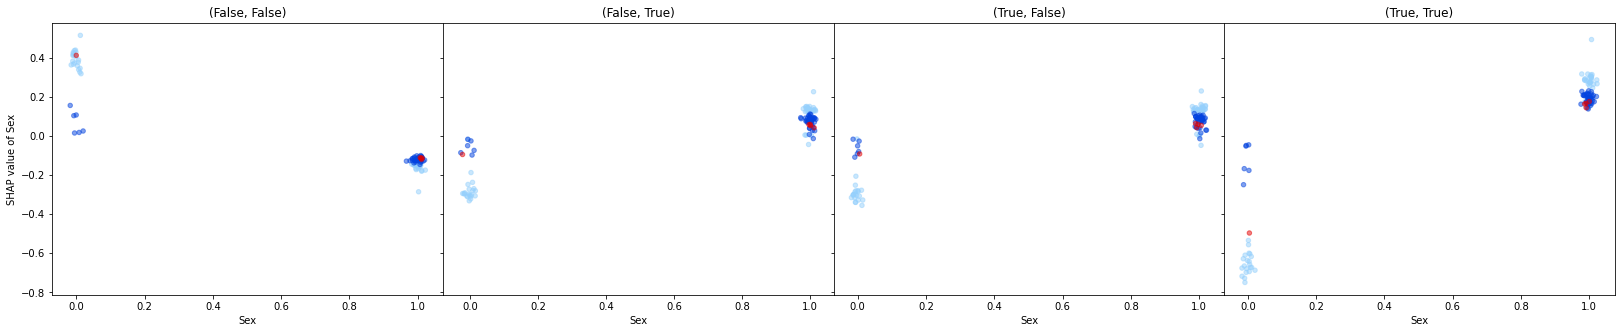

Capital Loss
[]


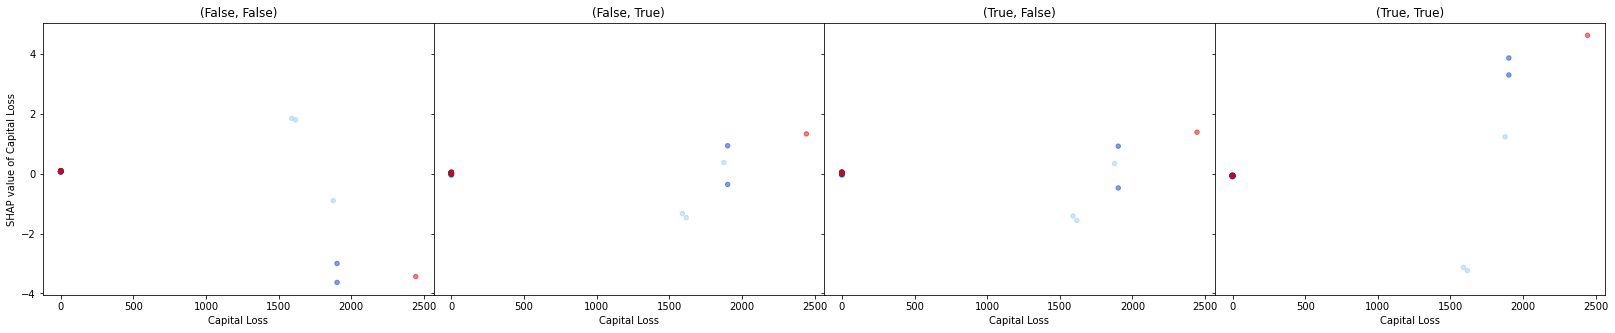

Workclass == 4.0
[]


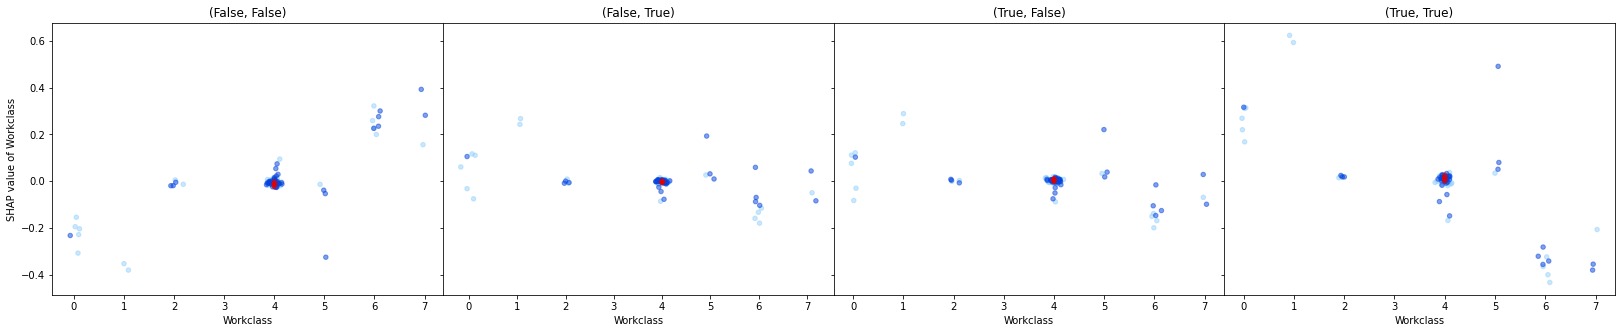

Race == 4.0
[]


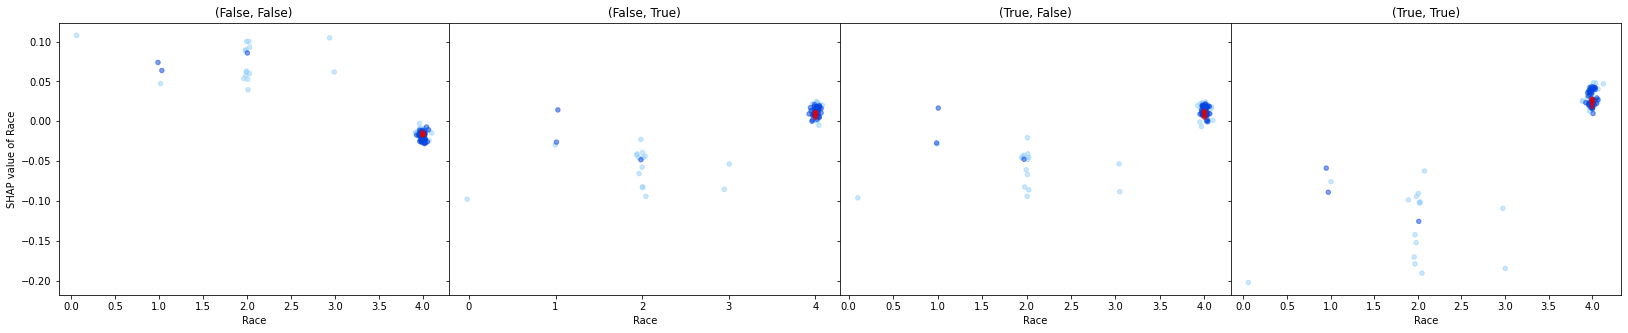

Country == 39.0
[]


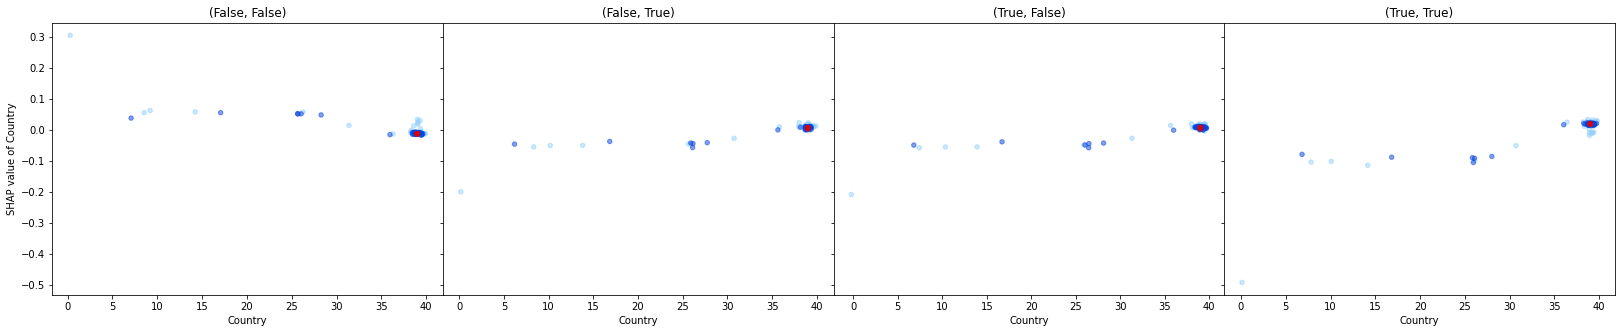

In [50]:
node.root.plot_feature_dependence(focus=node, print_stats=True)

### Node 1 (RLRRR)

In [51]:
path = [node]
node = node.right.get_last_child_before_focus_class_split()
node, node.class_counts, node.distance

(RLRRR,
 (True, False)    1
 dtype: int64,
 0)

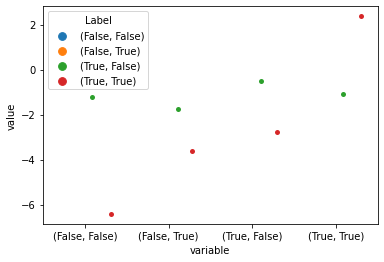

In [52]:
node.get_parent().plot_outcomes()

Capital Loss == 2444.0
[Lower CF: Capital Loss == 2384.0 --> {'(False, False)': 1}]


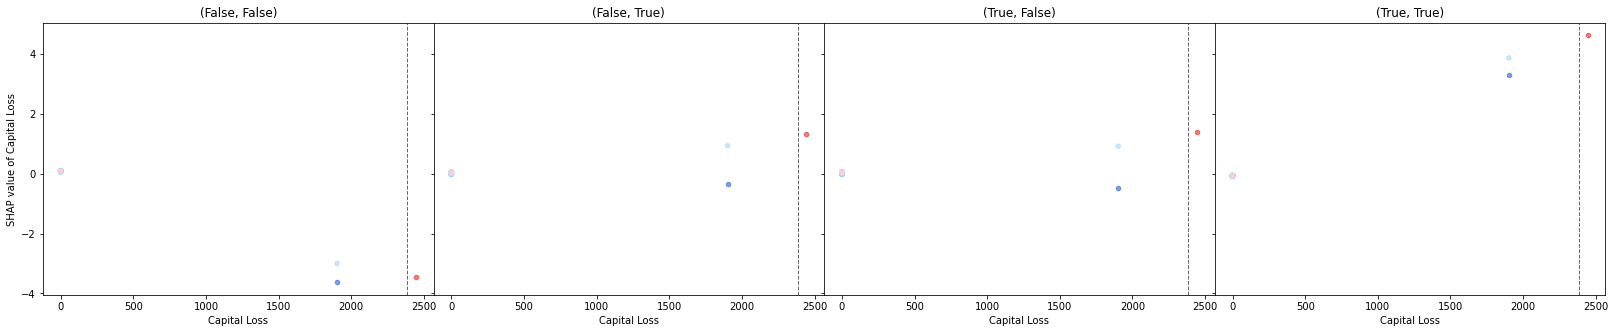

Relationship == 0.0
[Upper CF: Relationship == 3.0 --> {'(False, False)': 1}]


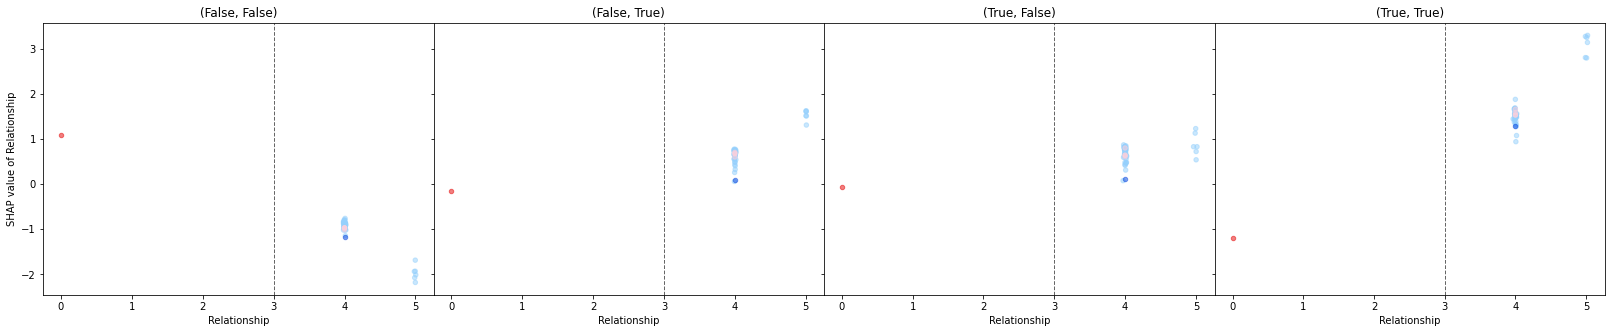

Education-Num == 10.0
[Lower CF: Education-Num == 8.0 --> {'(False, False)': 1},
 Upper CF: Education-Num == 13.0 --> {'(True, True)': 1}]


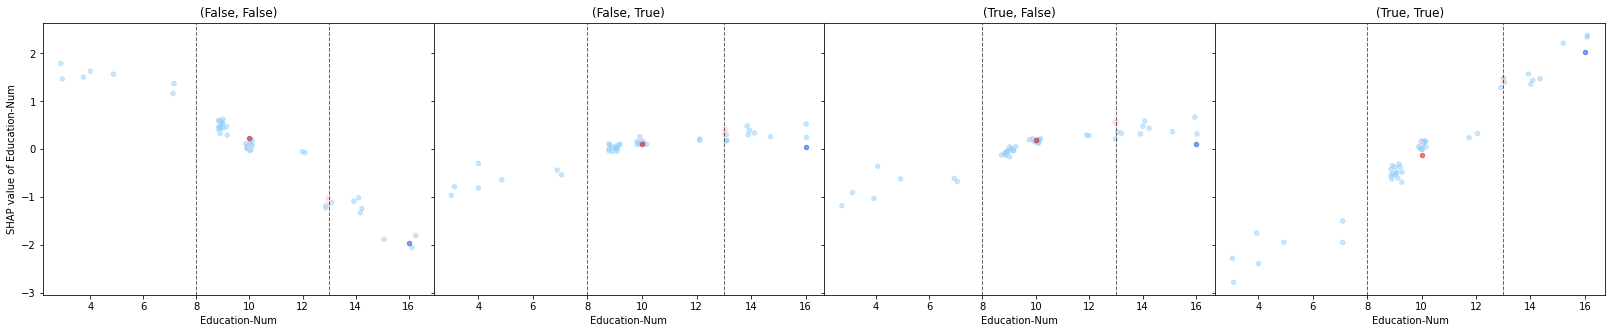

Age == 42.0
[Lower CF: Age == 35.0 --> {'(False, False)': 1}]


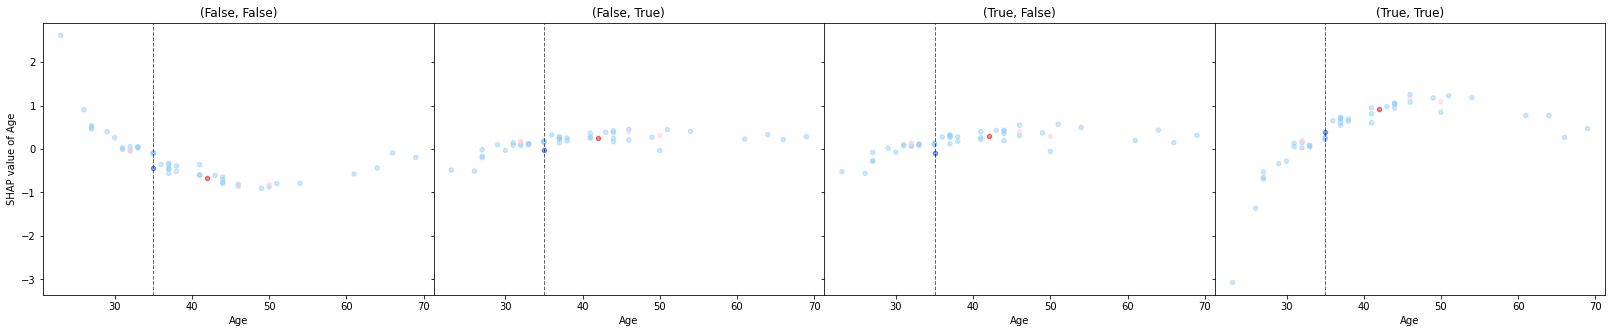

Occupation == 4.0
[Lower CF: Occupation == 2.0 --> {'(False, False)': 1},
 Upper CF: Occupation == 5.0 --> {'(False, False)': 1}]


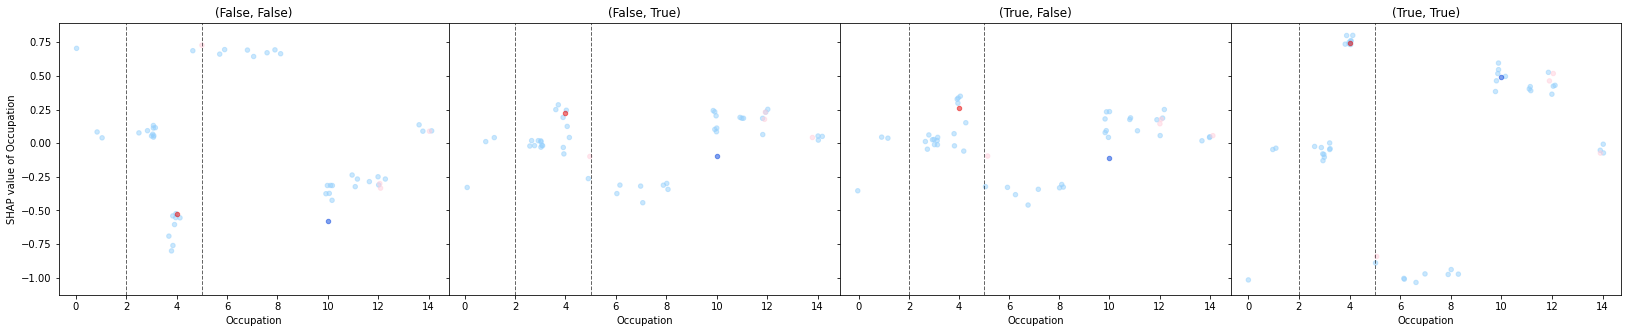

Capital Gain == 0.0
[Upper CF: Capital Gain == 57.0 --> {'(False, False)': 1}]


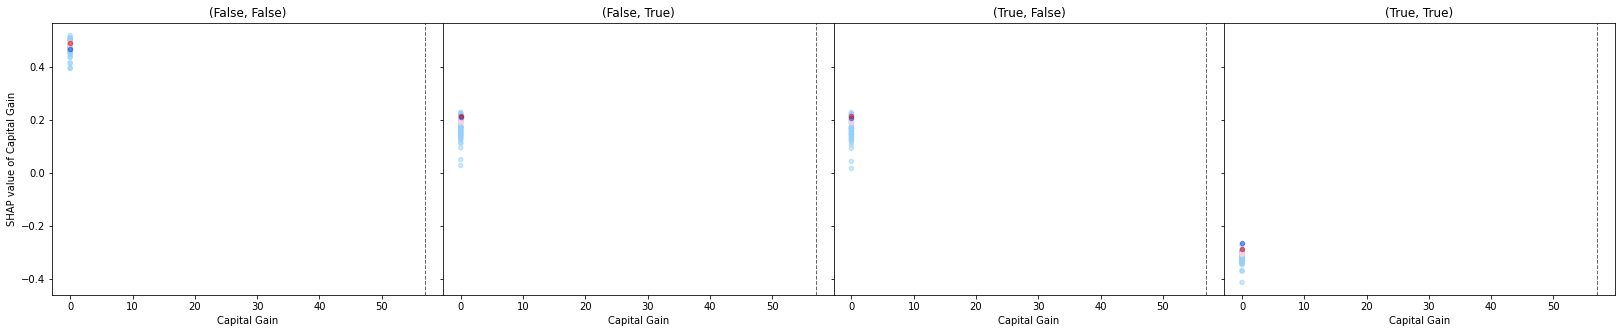

Hours per week == 40.0
[Lower CF: Hours per week == 34.0 --> {'(False, False)': 1},
 Upper CF: Hours per week == 45.0 --> {'(True, True)': 1}]


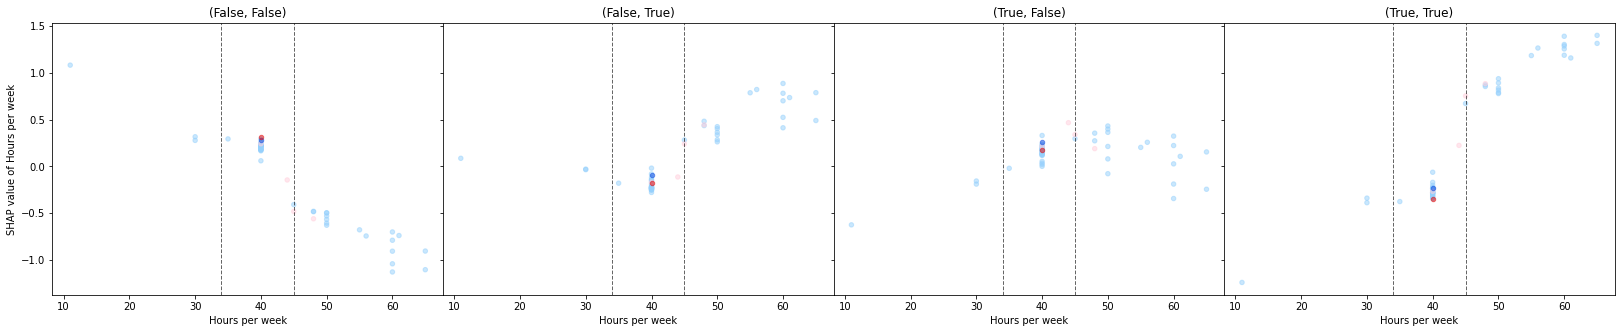

Sex == 0.0
[Upper CF: Sex == 1.0 --> {'(True, True)': 1}]


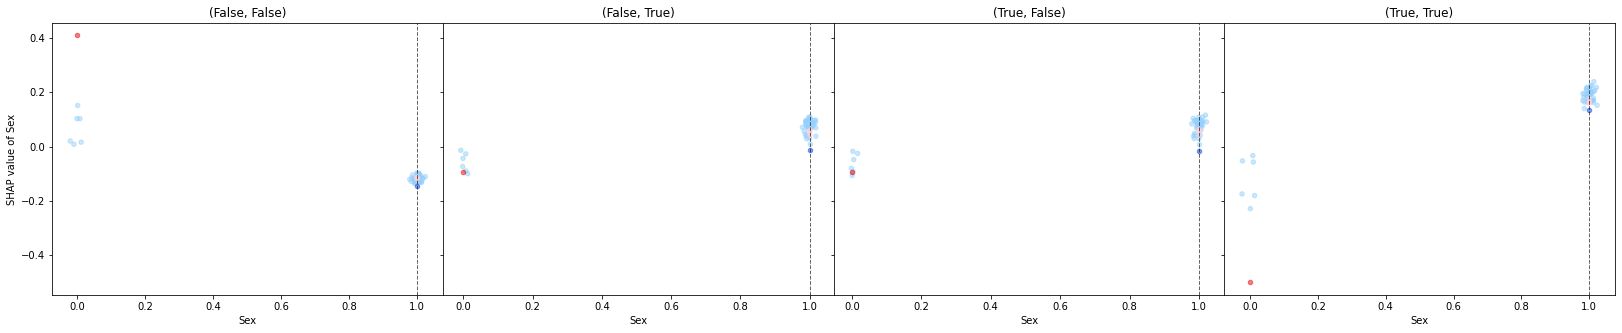

Marital Status == 4.0
[]


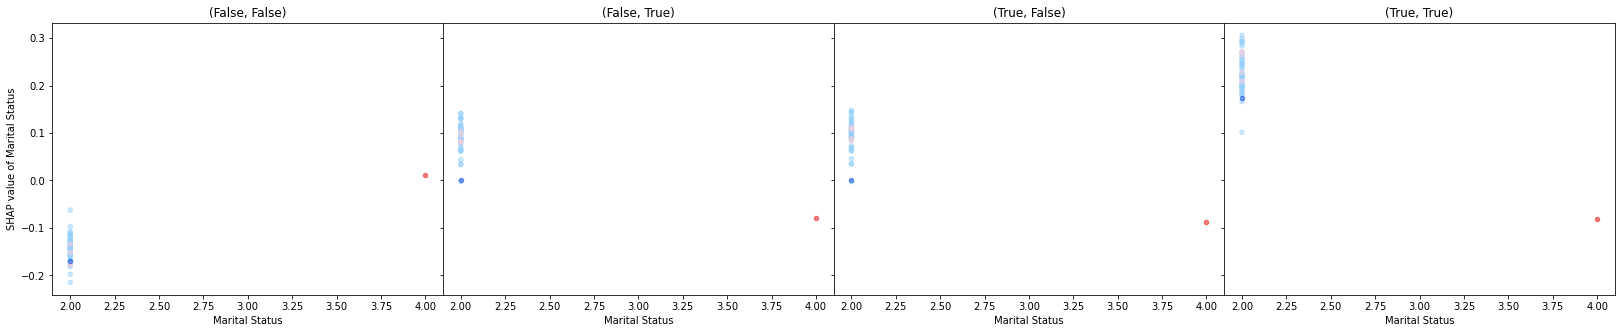

In [53]:
path[-1].plot_feature_dependence(*node.parent.features_ordered[:9], focus=node.parent, print_stats=True)

### Node 2 (RLL)

In [54]:
node = path[-1].left.get_last_child_before_focus_class_split()
node, node.class_counts, node.distance

(RLL,
 (False, False)    32
 (True, True)      11
 (True, False)      4
 dtype: int64,
 51.498931921916956)

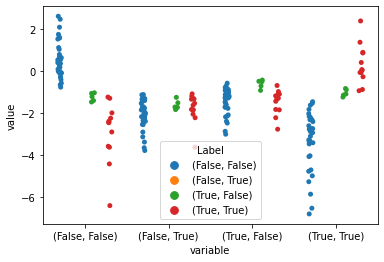

In [55]:
node.get_parent().plot_outcomes()

Relationship == 4.0
[Lower CF: Relationship == 3.0 --> {'(False, False)': 4}]


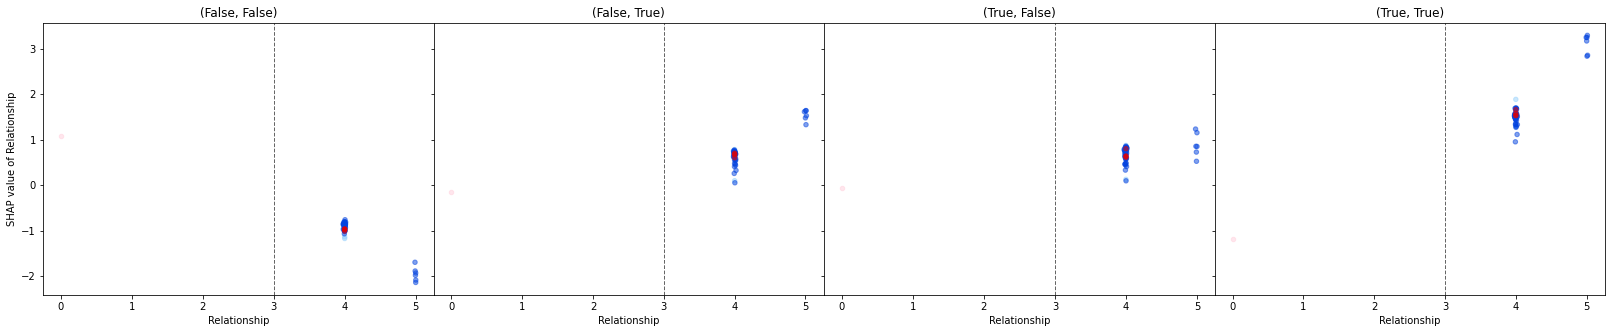

10.0 <= Education-Num <= 13.0
[Lower CF: Education-Num == 9.0 --> {'(False, False)': 4}]


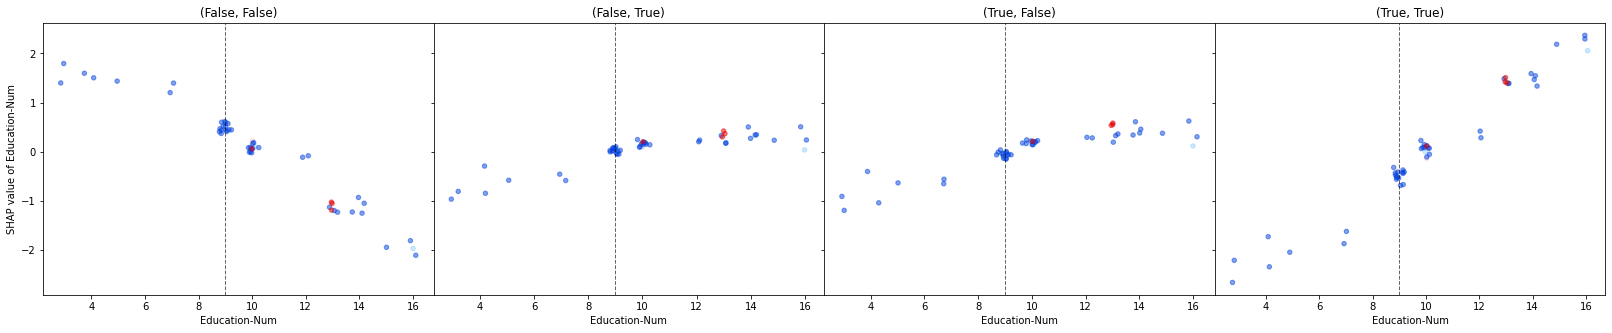

40.0 <= Hours per week <= 48.0
[Lower CF: Hours per week == 34.0 --> {'(False, False)': 4},
 Upper CF: Hours per week == 55.0 --> {'(True, True)': 4}]


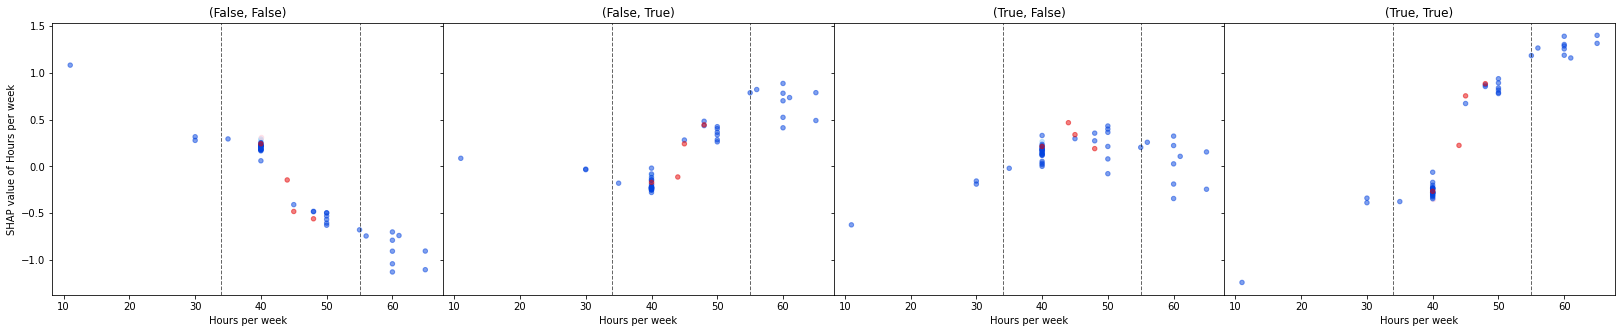

32.0 <= Age <= 50.0
[Lower CF: Age == 26.0 --> {'(False, False)': 4}]


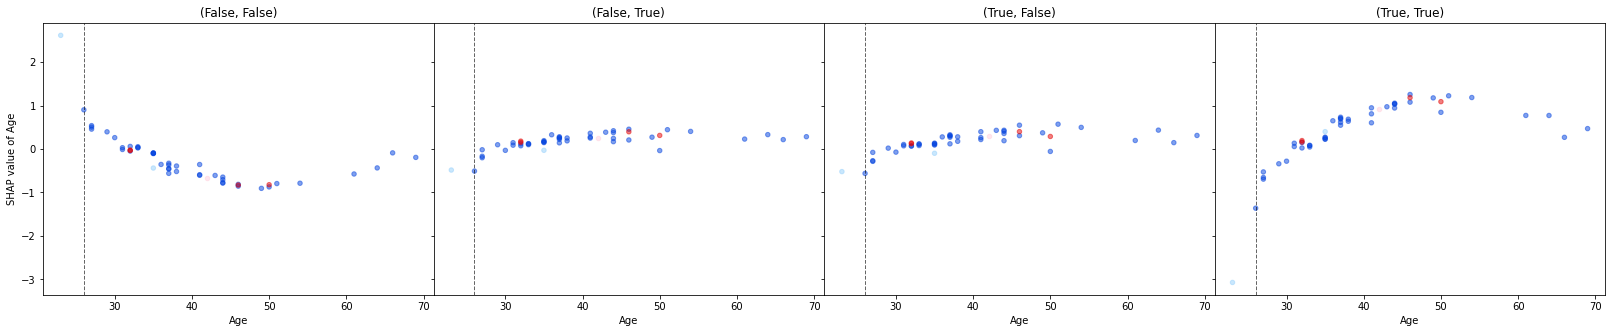

5.0 <= Occupation
[]


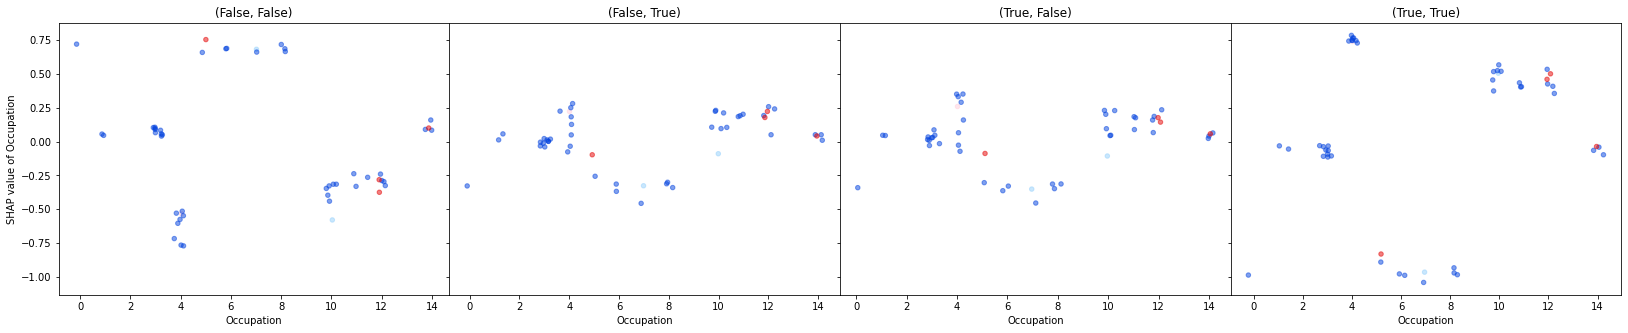

Capital Gain == 0.0
[Upper CF: Capital Gain == 57.0 --> {'(False, False)': 4}]


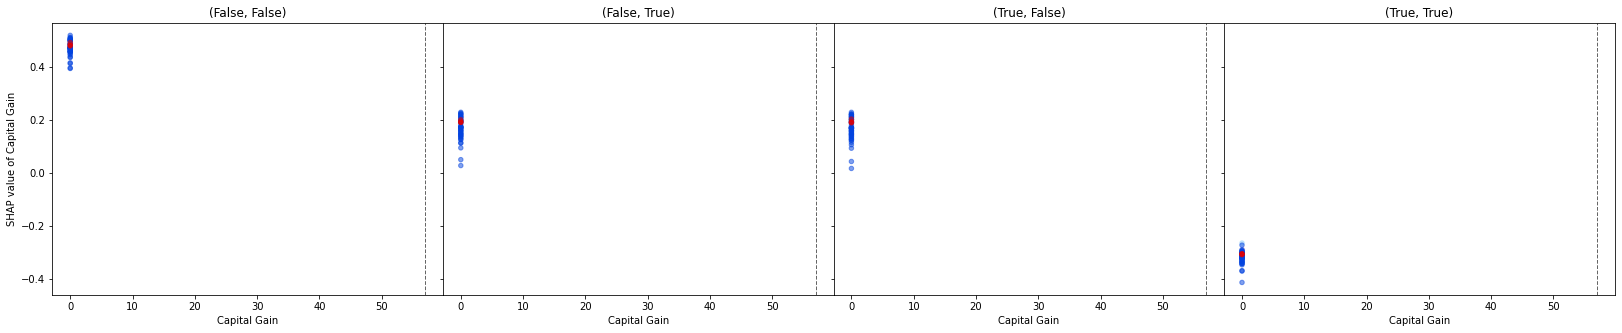

Marital Status == 2.0
[]


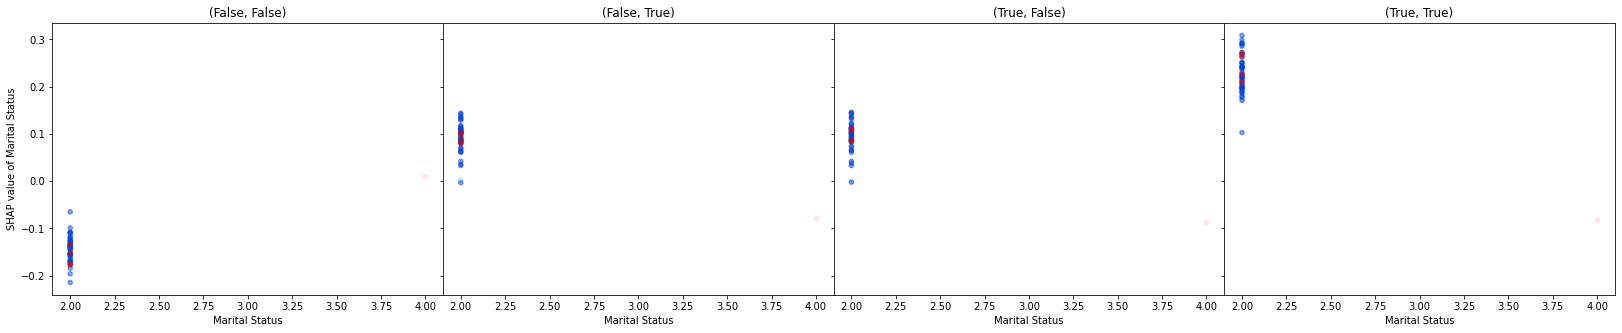

Sex == 1.0
[]


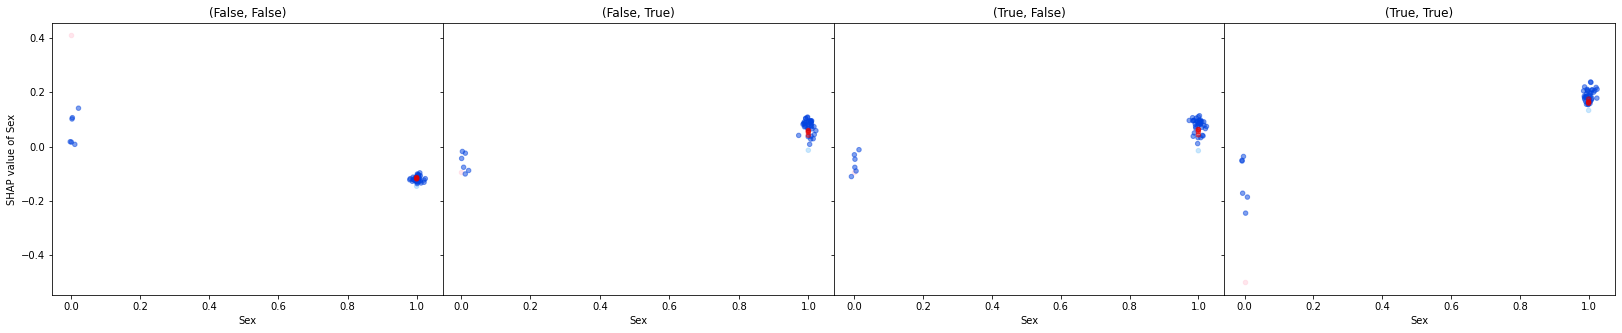

Capital Loss == 0.0
[Upper CF: Capital Loss == 1448.0 --> {'(True, True)': 4}]


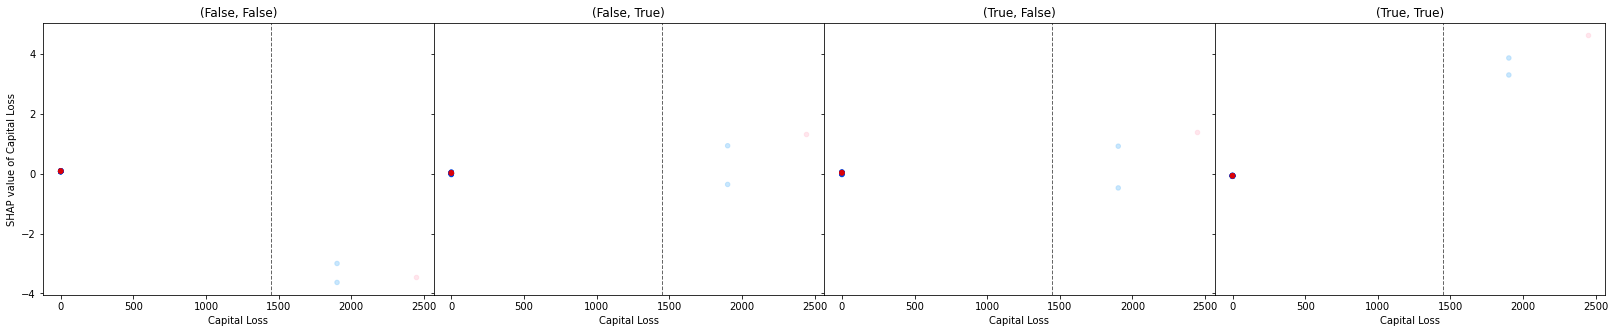

In [56]:
path[-1].plot_feature_dependence(*node.features_ordered[:-3], focus=node, print_stats=True)

### Node 2.1 (RLLRRRRRL)

In [57]:
path.append(node)
node = node.right.get_last_child_before_focus_class_split()
node, node.class_counts, node.distance

(RLLRRRRRL,
 (True, False)    1
 dtype: int64,
 0)

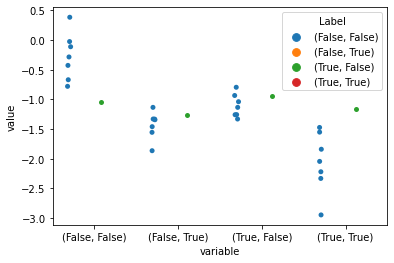

In [58]:
node.get_parent().plot_outcomes()

Relationship == 4.0
[Lower CF: Relationship == 3.0 --> {'(False, False)': 1}]


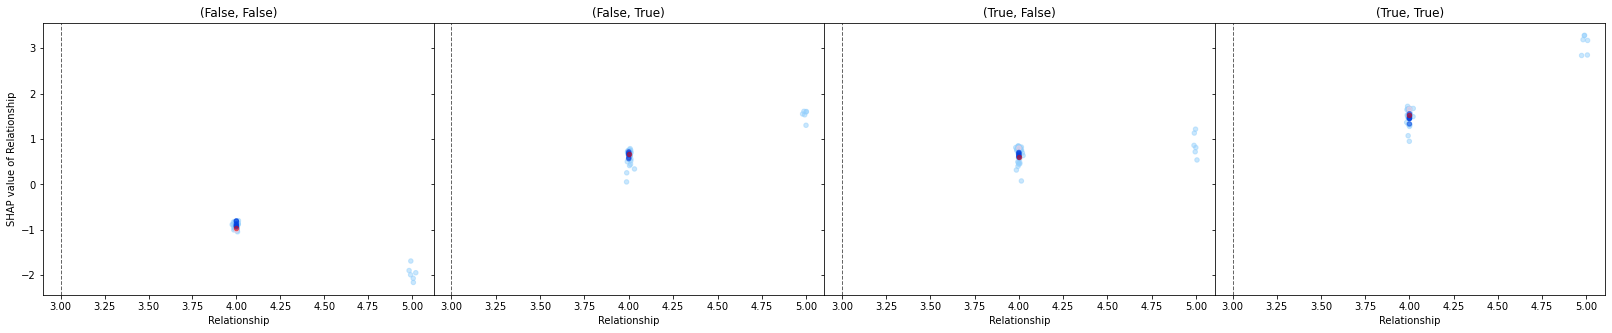

Hours per week == 48.0
[Lower CF: Hours per week == 44.0 --> {'(False, False)': 1},
 Upper CF: Hours per week == 55.0 --> {'(True, True)': 1}]


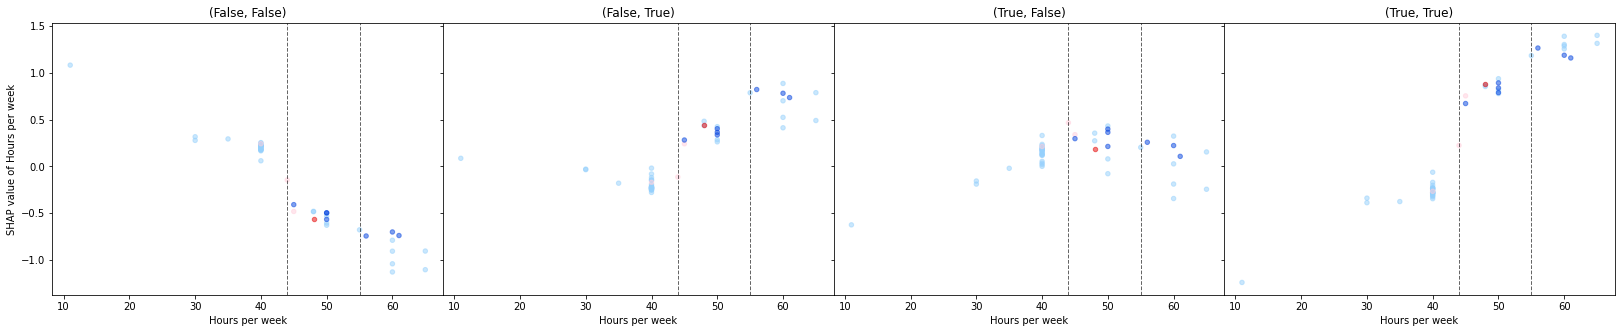

Capital Gain == 0.0
[Upper CF: Capital Gain == 57.0 --> {'(False, False)': 1}]


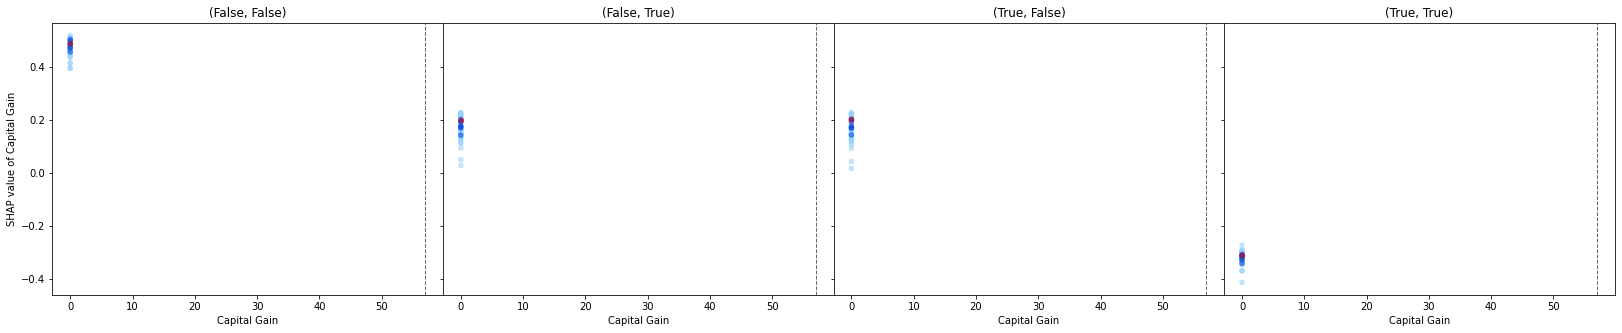

Occupation == 14.0
[Lower CF: Occupation == 13.0 --> {'(True, True)': 1}]


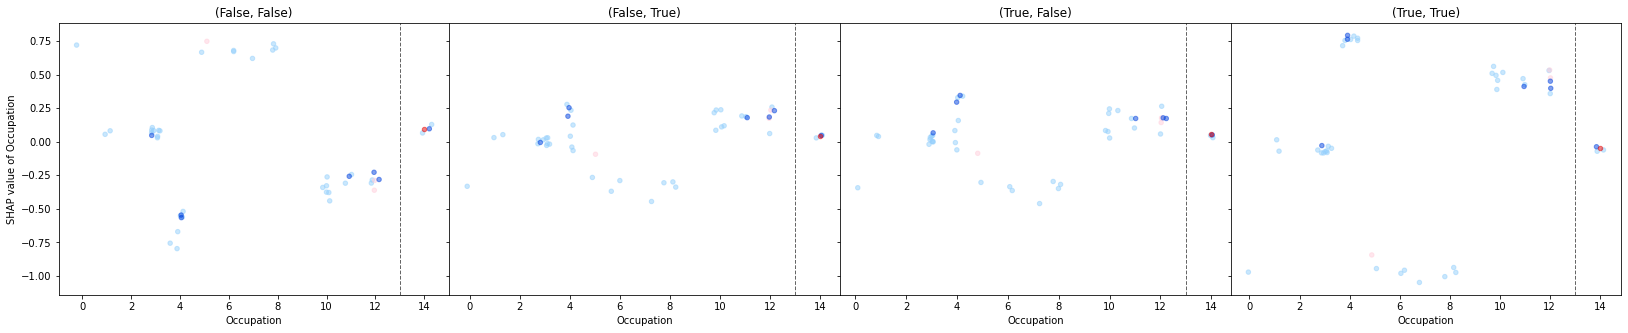

Age == 46.0
[Lower CF: Age == 44.0 --> {'(False, False)': 1},
 Upper CF: Age == 60.0 --> {'(False, False)': 1}]


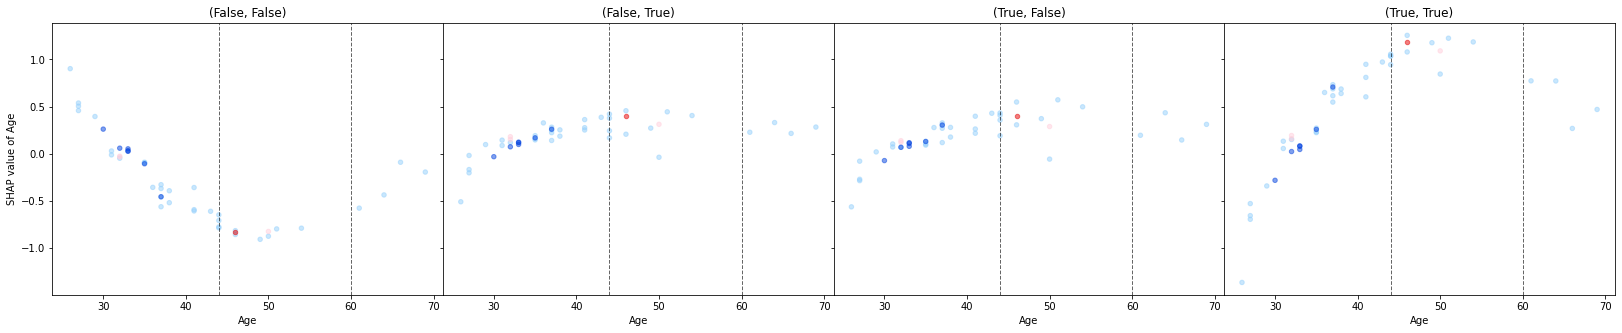

Education-Num == 10.0
[Lower CF: Education-Num == 9.0 --> {'(False, False)': 1},
 Upper CF: Education-Num == 12.0 --> {'(False, False)': 1}]


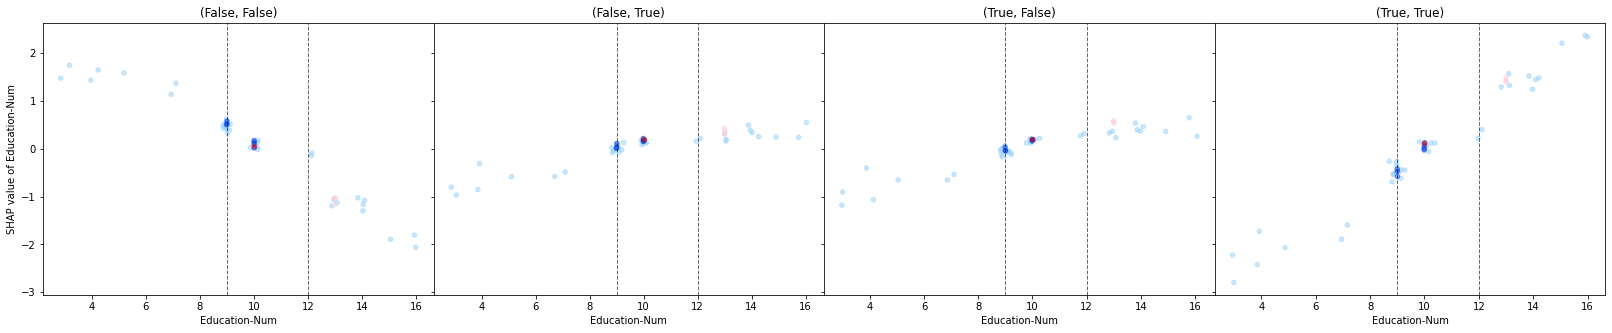

Marital Status == 2.0
[Upper CF: Marital Status == 3.0 --> {'(False, False)': 1}]


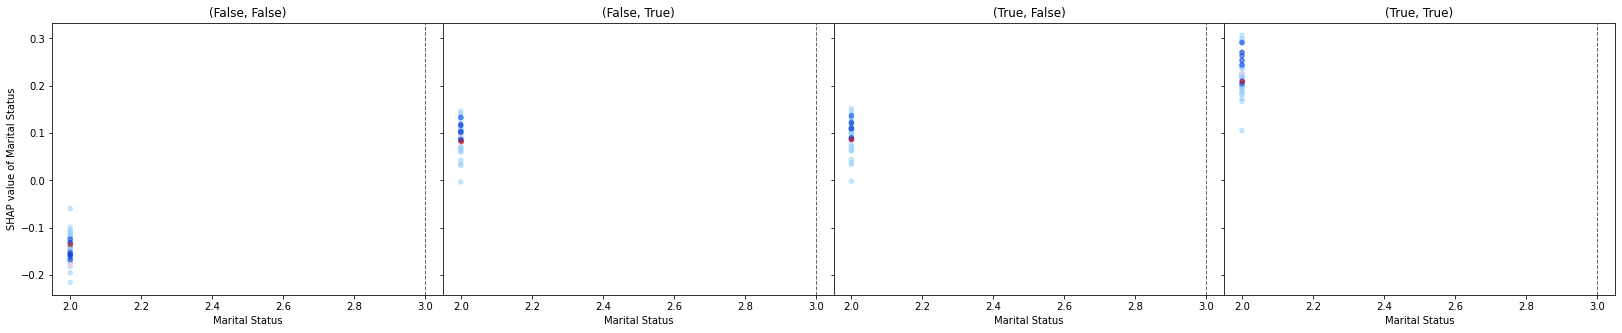

Sex == 1.0
[Lower CF: Sex == 0.0 --> {'(False, False)': 1}]


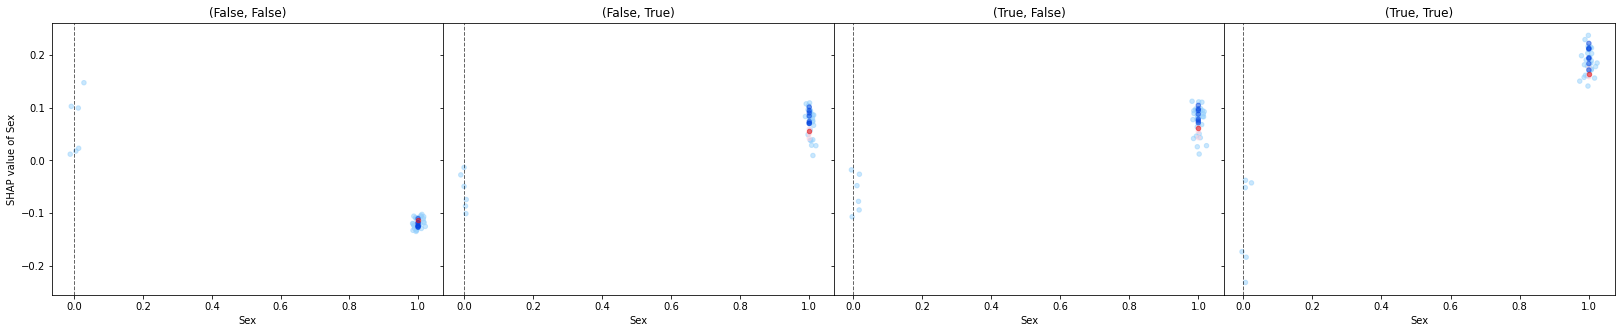

Capital Loss == 0.0
[Upper CF: Capital Loss == 1448.0 --> {'(True, True)': 1}]


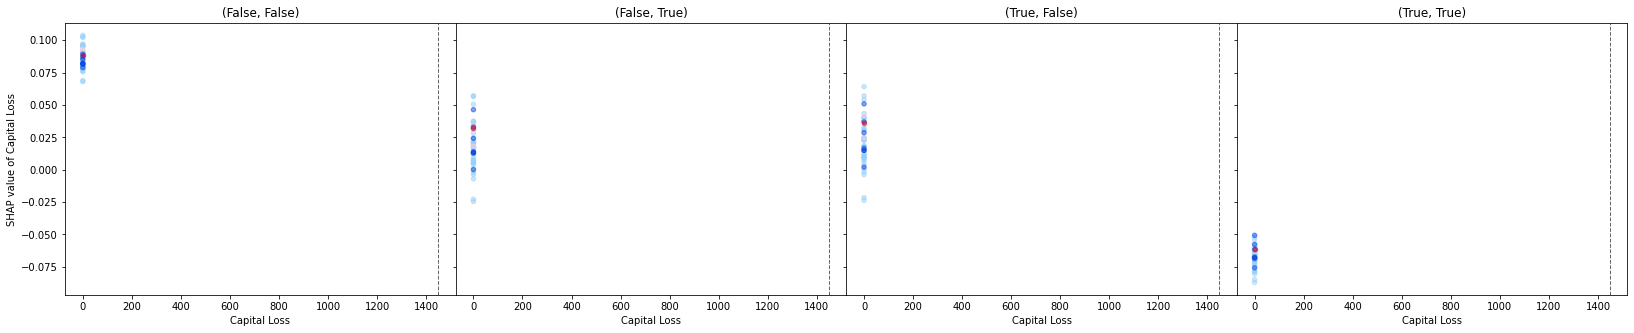

Workclass == 4.0
[Lower CF: Workclass == 1.0 --> {'(True, True)': 1},
 Upper CF: Workclass == 6.0 --> {'(False, False)': 1}]


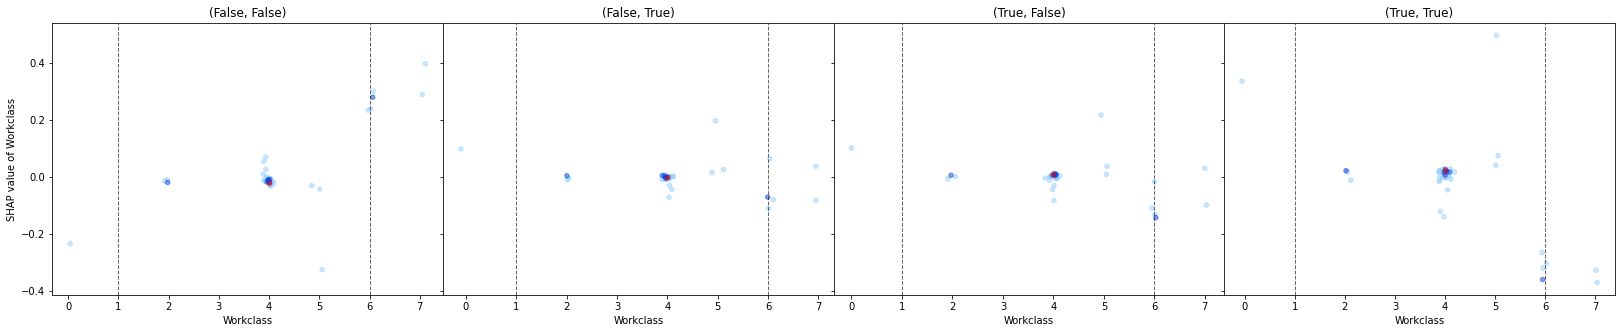

In [59]:
path[-1].plot_feature_dependence(*node.parent.features_ordered[:-2], focus=node.parent, print_stats=True)

### Node 2.2 (RLLL)

In [60]:
node = path[-1].left.get_last_child_before_focus_class_split()
node, node.class_counts, node.distance

(RLLL,
 (True, True)      9
 (True, False)     3
 (False, False)    1
 dtype: int64,
 20.43439220003462)

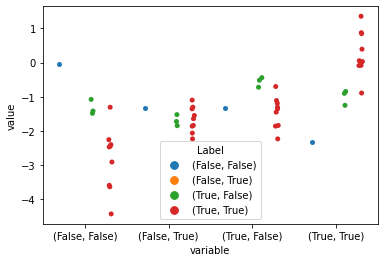

In [61]:
node.plot_outcomes()

Education-Num == 13.0
[Lower CF: Education-Num == 12.0 --> {'(False, False)': 3}]


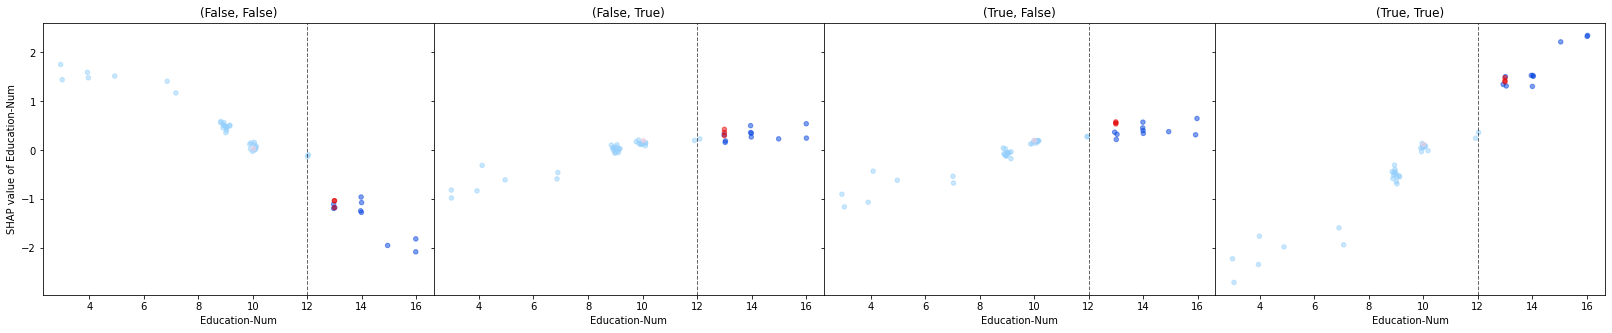

Relationship == 4.0
[Lower CF: Relationship == 3.0 --> {'(False, False)': 3},
 Upper CF: Relationship == 5.0 --> {'(True, True)': 3}]


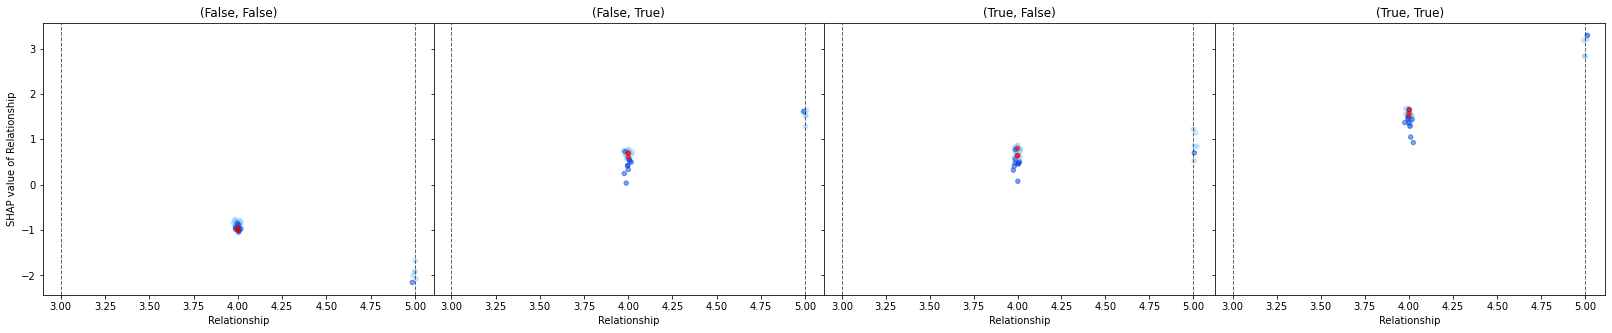

40.0 <= Hours per week <= 45.0
[Lower CF: Hours per week == 34.0 --> {'(False, False)': 3},
 Upper CF: Hours per week == 46.0 --> {'(True, True)': 3}]


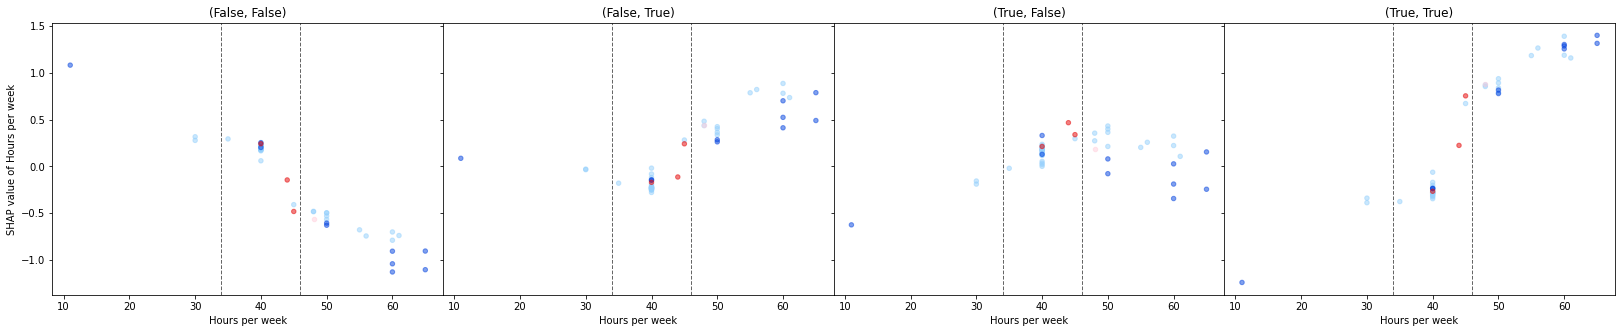

32.0 <= Age <= 50.0
[Lower CF: Age == 26.0 --> {'(False, False)': 3}]


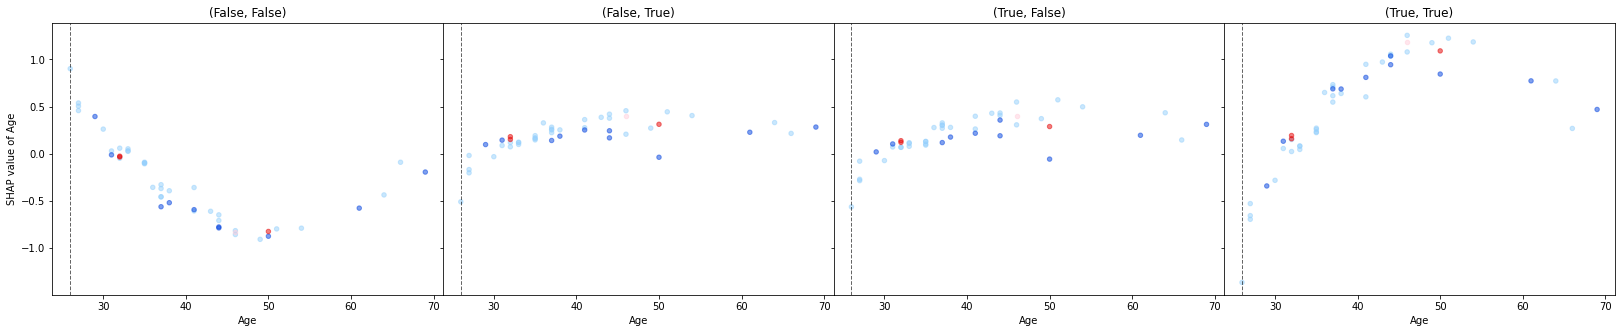

5.0 <= Occupation <= 12.0
[]


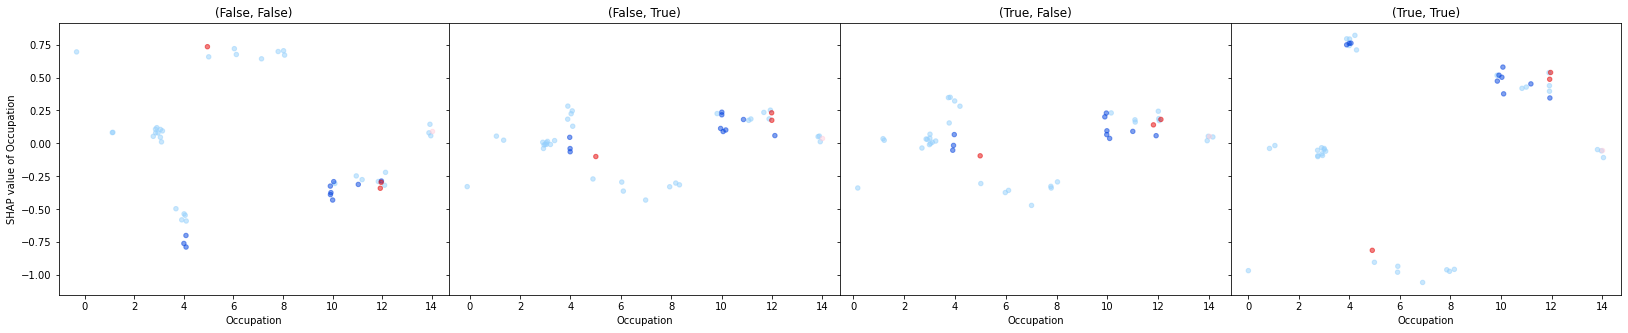

Capital Gain == 0.0
[Upper CF: Capital Gain == 57.0 --> {'(False, False)': 3}]


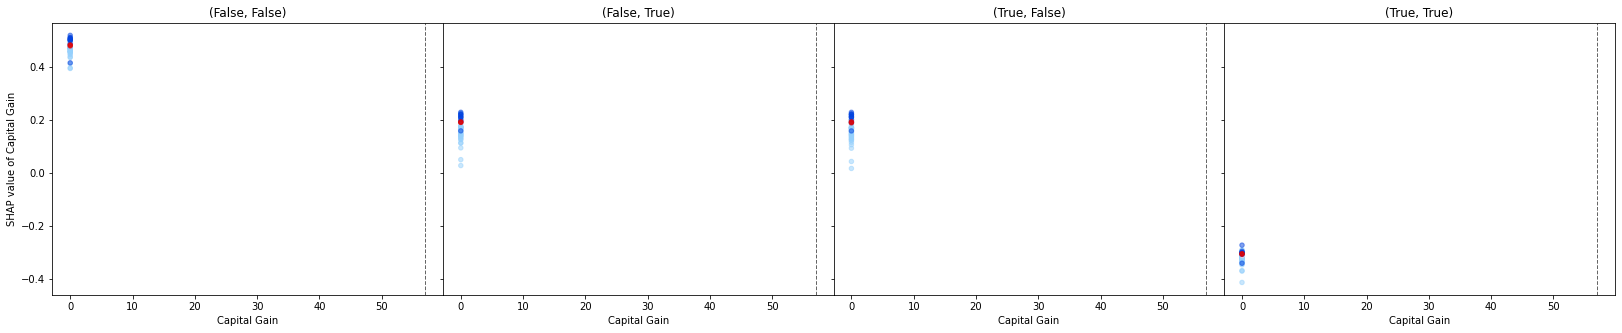

In [62]:
path[-1].plot_feature_dependence(*node.features_ordered[:-6], focus=node, print_stats=True)

### Node 2.2.1 (RLLLRRRR)

In [63]:
path.append(node)
node = node.right.get_last_child_before_focus_class_split()
node, node.class_counts, node.distance

(RLLLRRRR,
 (True, False)    2
 dtype: int64,
 0.5621804516466264)

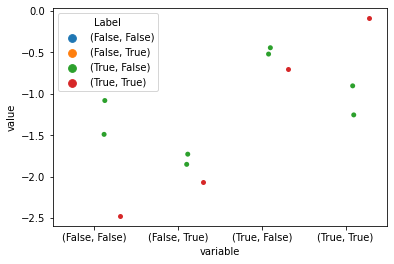

In [64]:
node.get_parent().plot_outcomes()

Education-Num == 13.0
[Lower CF: Education-Num == 12.0 --> {'(False, False)': 2}]


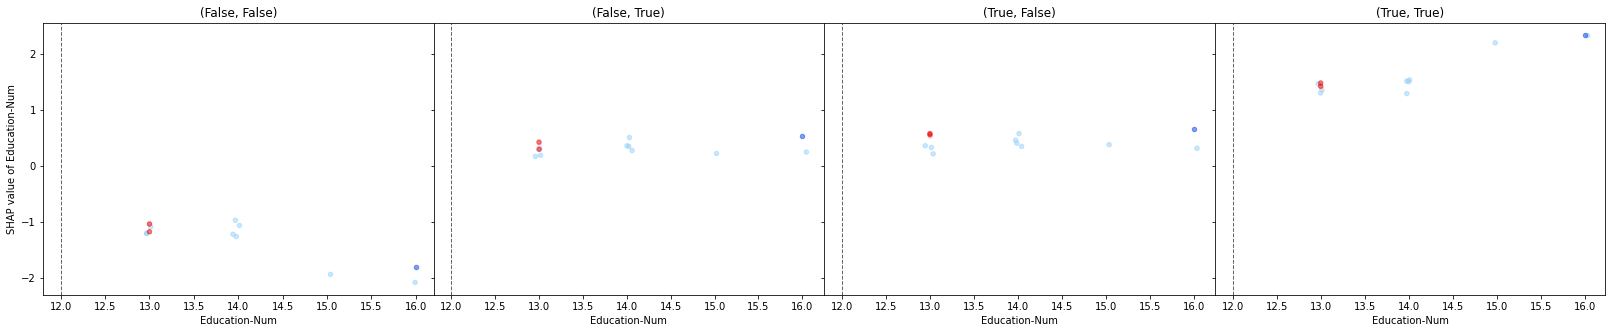

Relationship == 4.0
[Lower CF: Relationship == 3.0 --> {'(False, False)': 2},
 Upper CF: Relationship == 5.0 --> {'(True, True)': 2}]


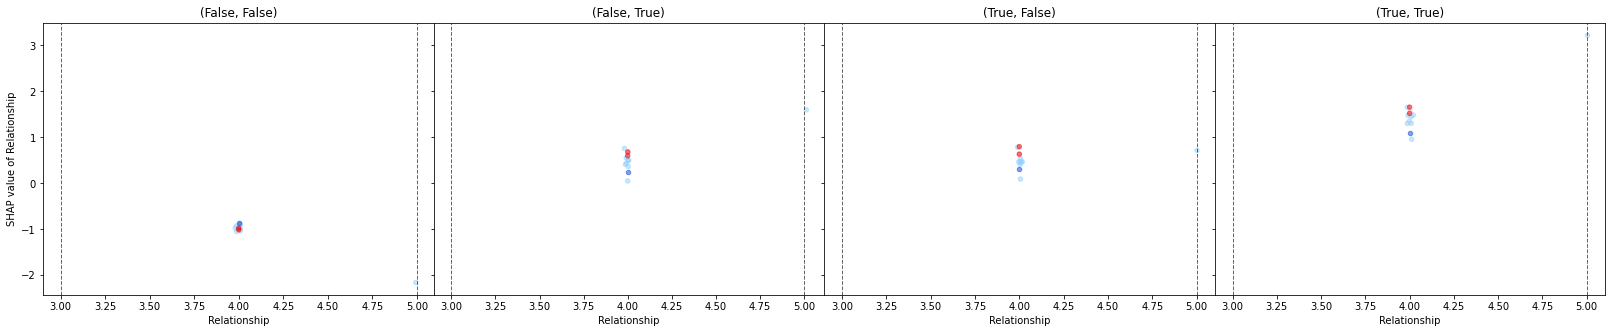

Capital Gain == 0.0
[Upper CF: Capital Gain == 57.0 --> {'(False, False)': 2}]


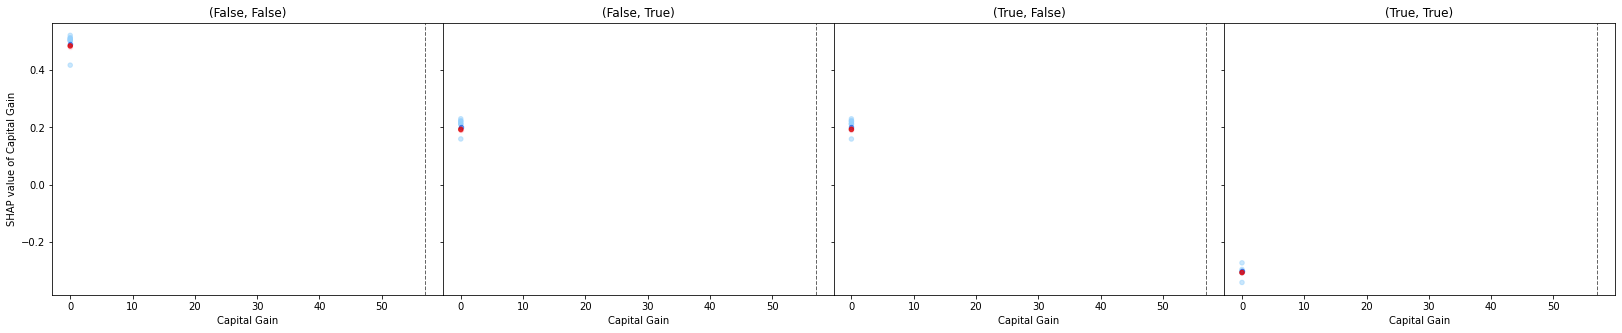

Occupation == 12.0
[Lower CF: Occupation == 9.0 --> {'(False, False)': 2}]


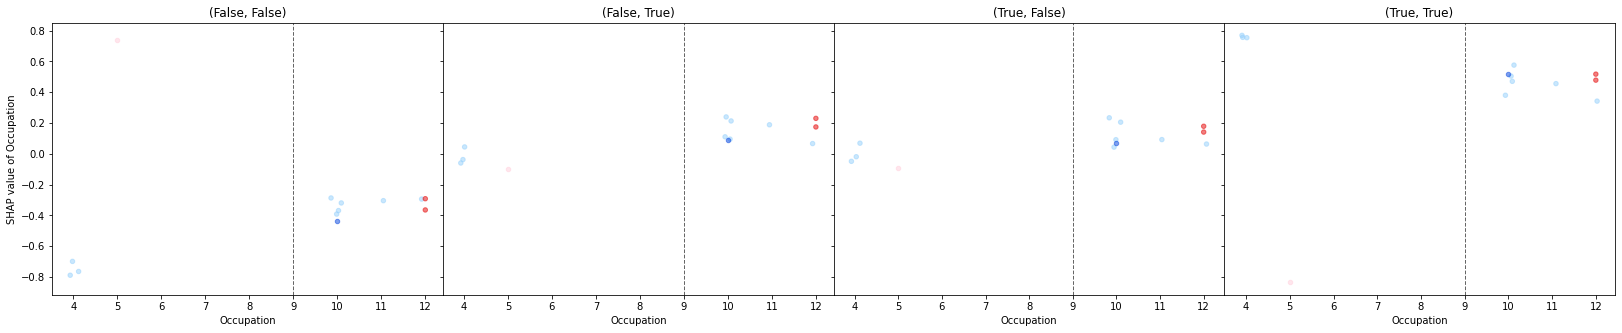

Age == 32.0
[Lower CF: Age == 26.0 --> {'(False, False)': 2}]


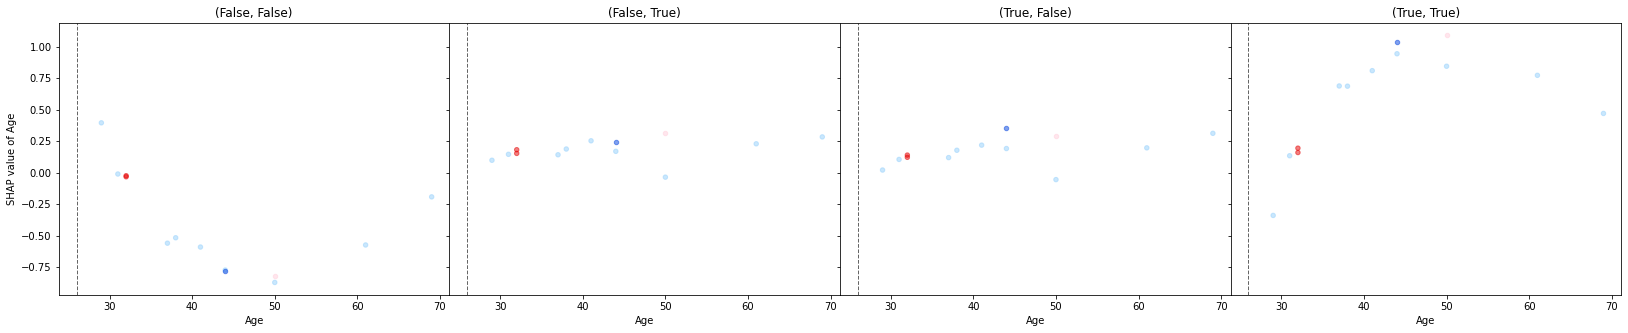

40.0 <= Hours per week <= 44.0
[Lower CF: Hours per week == 34.0 --> {'(False, False)': 2},
 Upper CF: Hours per week == 45.0 --> {'(True, True)': 2}]


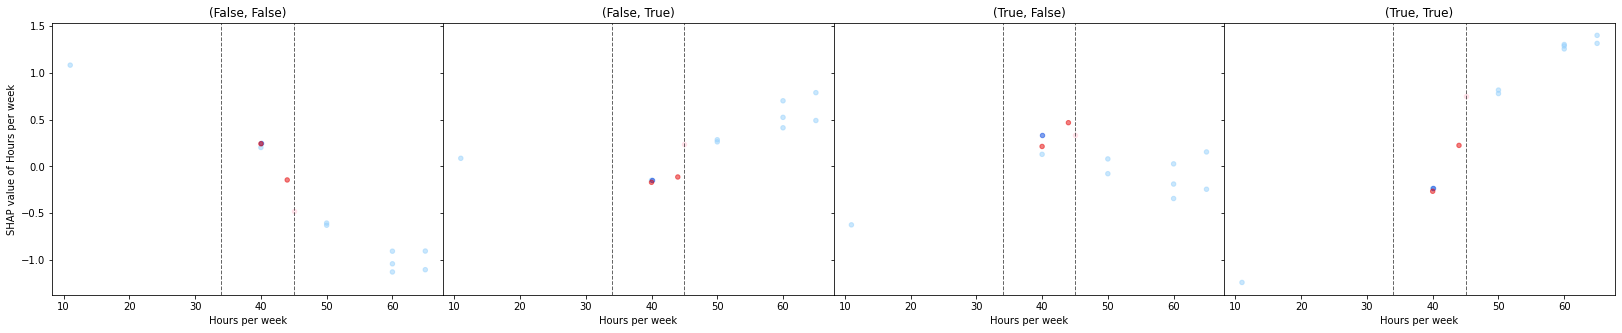

In [65]:
path[-1].plot_feature_dependence(*node.parent.features_ordered[:-6], focus=node.parent, print_stats=True)

# Additional plots

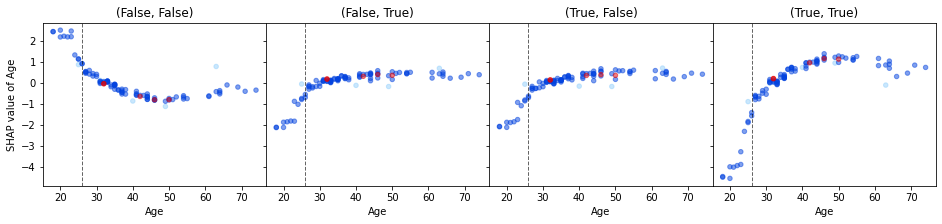

<Figure size 432x288 with 0 Axes>

In [22]:
node = node.root.get('R')
node.root.plot_feature_dependence('Age', focus=node, alpha=0.5, figsize=(4, 3))
plt.savefig('adult-global-depplots-01-age.pdf')

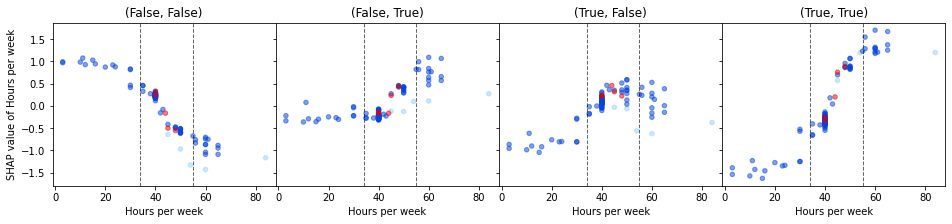

<Figure size 432x288 with 0 Axes>

In [23]:
node = node.root.get('R')
node.root.plot_feature_dependence('Hours per week', focus=node, alpha=0.5, figsize=(4, 3))
plt.savefig('adult-global-depplots-01-hours.pdf')

In [24]:
plot_joint_feature_dependence('Relationship', **{
    'Main Node': node.root.get('R'),
    'Node 1': node.root.get('RLRLR'),
    'Node 2': node.root.get('RRLLR')
})
plt.savefig('adult-depplots-01-relationship.pdf')

NameError: name 'plot_joint_feature_dependence' is not defined

In [ ]:
plot_joint_feature_dependence('Education-Num', **{
    'Main Node': node.root.get('R'),
    'Node 1': node.root.get('RLRLR'),
    'Node 2.1': node.root.get('RRLLRL'),
    'Node 2.2': node.root.get('RRLLRRLR')
})
plt.savefig('adult-depplots-01-education.pdf')